# Green Maritime Corridors - Canal de Panamá

quarto preview

## Librerías y dependencias

In [1]:
#| label: librerias
#| warning: false
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, f_regression

## Lectura y limpieza inicial

In [2]:
#| label: lectura_limpieza_inicial
# Lectura y limpieza inicial
ruta_data = r"C:\Users\limco\Documents\DATA_C\sample_training.parquet"
df_raw = pd.read_parquet(ruta_data, engine='fastparquet')

# Limpiar nombres de columnas
df_raw.columns = (
    df_raw.columns.str.strip()
                  .str.replace(' ', '_')
                  .str.replace(r'[^\w]', '', regex=True)
)

# Convertir columna de fecha
df_raw['first_dt_pos_utc'] = pd.to_datetime(df_raw['first_dt_pos_utc'])

## Partición externa

In [3]:
#| label: particion_externa
# Partición externa
fecha_corte = pd.to_datetime('2019-06-01')
train_val = df_raw[df_raw['first_dt_pos_utc'] < fecha_corte].copy()
test_ext  = df_raw[df_raw['first_dt_pos_utc'] >= fecha_corte].copy()

# Exploración inicial (EDA)

## Resumen de train\_val

In [4]:
#| label: resumen_train_val
#| warning: false
from tabulate import tabulate

print(f"Cantidad de filas en train_val: {len(train_val)}")
print(f"Cantidad de columnas en train_val: {len(train_val.columns)}\n")

Cantidad de filas en train_val: 27532
Cantidad de columnas en train_val: 46



## Exploración inicial de datos (sin h3\_sequence)

In [5]:
#| label: exploracion_i
#| warning: false
from tabulate import tabulate

# Columnas a mostrar (excluyendo 'h3_sequence')
cols_to_show = [c for c in train_val.columns if c != 'h3_sequence']

# Mostrar primeras filas
print(tabulate(train_val[cols_to_show].head(5), headers='keys', tablefmt='psql'))

+----+-----------+---------------------------+---------------------------+---------+---------------------+---------------------+---------------------------+------------------+--------------+-----------------+-----------------+------------------------+------------------+---------------------+----------------+--------------+--------------+---------+------------------+--------------+--------------------+---------------+-------+--------------+-------------------+---------+------------+----------------+------------------+-----------------+---------------------+---------------------+----------------------------+-----------------+------------------+------------------+-----------------------------+------------------+-----------------------+------------------------+----------+--------+----------+------------+-----------+
|    |      mmsi | start_leg                 | end_leg                   |   imo_x | ref_in              | ref_out             | port_before               | country_before   | 

## Revisión de tipos de datos

In [6]:
#| label: tipos_columnas
#| warning: false
from tabulate import tabulate

tipos = train_val.dtypes.reset_index()
tipos.columns = ['Columna', 'Tipo de dato']

print(tabulate(tipos, headers='keys', tablefmt='psql'))

+----+--------------------------+---------------------+
|    | Columna                  | Tipo de dato        |
|----+--------------------------+---------------------|
|  0 | mmsi                     | int32               |
|  1 | start_leg                | datetime64[ns, UTC] |
|  2 | end_leg                  | datetime64[ns, UTC] |
|  3 | h3_sequence              | object              |
|  4 | imo_x                    | int32               |
|  5 | ref_in                   | datetime64[us]      |
|  6 | ref_out                  | datetime64[us]      |
|  7 | port_before              | object              |
|  8 | country_before           | object              |
|  9 | port_after               | object              |
| 10 | country_after            | object              |
| 11 | op_phase                 | object              |
| 12 | StandardVesselType_x     | object              |
| 13 | GrossTonnage_x           | int32               |
| 14 | first_dt_pos_utc         | datetime64[us]

## Distribución de registros por buque

In [7]:
#| label: eda_secuencias
#| warning: false
from tabulate import tabulate

registros_por_buque = train_val.groupby("mmsi").size()
tabla_freq = registros_por_buque.value_counts().sort_index()
tabla_freq_df = tabla_freq.reset_index()
tabla_freq_df.columns = ["n_registros_por_buque", "n_buques"]
tabla_freq_df = tabla_freq_df.sort_values(by="n_buques", ascending=False).reset_index(drop=True)

La tabla muestra que la mayoría de los buques tienen pocos registros, la mayor parte entre 1 y 5 pasos. Solo unos pocos buques tienen muchos registros (más de 50), lo que indica que unos pocos son muy activos mientras la mayoría realiza trayectorias cortas o tiene menos datos registrados


In [8]:
#| label: a_secuencias
#| warning: false
print("\nTabla de registros por buque ordenada por n_buques:")
print(tabulate(tabla_freq_df, headers='keys', tablefmt='psql'))


Tabla de registros por buque ordenada por n_buques:
+----+-------------------------+------------+
|    |   n_registros_por_buque |   n_buques |
|----+-------------------------+------------|
|  0 |                       4 |        588 |
|  1 |                       1 |        381 |
|  2 |                       5 |        380 |
|  3 |                       9 |        172 |
|  4 |                       2 |        166 |
|  5 |                       8 |        158 |
|  6 |                      10 |        123 |
|  7 |                       3 |         92 |
|  8 |                       6 |         65 |
|  9 |                      13 |         55 |
| 10 |                      15 |         39 |
| 11 |                      14 |         38 |
| 12 |                      18 |         36 |
| 13 |                       7 |         31 |
| 14 |                      17 |         28 |
| 15 |                      19 |         24 |
| 16 |                      12 |         24 |
| 17 |                     

### Gráfico de distribución de registros por buque

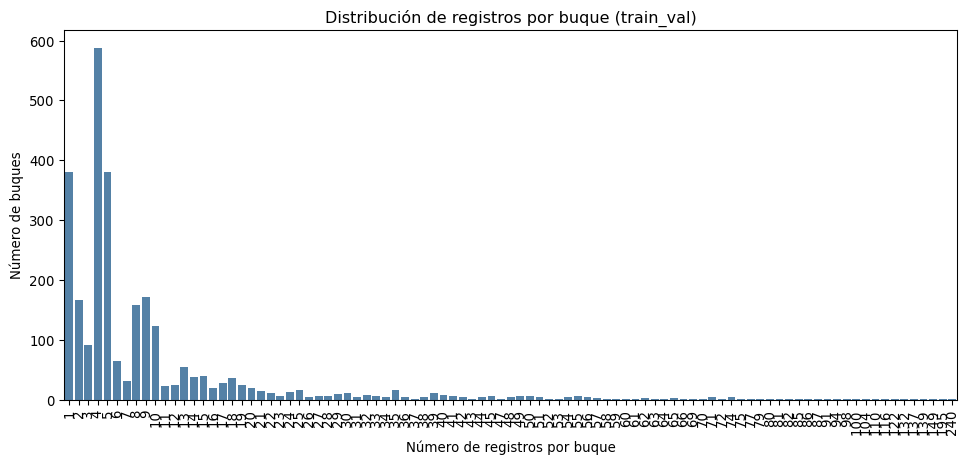

In [9]:
#| label: eda_grafico
#| warning: false
import matplotlib.pyplot as plt
import seaborn as sns

tabla_freq_df['n_buques_acum'] = tabla_freq_df['n_buques'].cumsum()

plt.figure(figsize=(12,5))
sns.barplot(
    data=tabla_freq_df, 
    x='n_registros_por_buque', 
    y='n_buques', 
    color='steelblue'
)
plt.xlabel("Número de registros por buque")
plt.ylabel("Número de buques")
plt.title("Distribución de registros por buque (train_val)")
plt.xticks(rotation=90)
plt.show()

## Verificar viajes puerto–puerto

In [10]:
#| label: eda_viajes_puerto
#| warning: false
viajes_incompletos = train_val[
    train_val['port_before'].isna() | 
    train_val['port_after'].isna()  |
    (train_val['port_before'].str.lower().isin(['', 'desconocido'])) |
    (train_val['port_after'].str.lower().isin(['', 'desconocido']))
]

print("Cantidad de registros con viajes incompletos (puertos faltantes o desconocidos):", len(viajes_incompletos))
print(tabulate(
    viajes_incompletos[['mmsi','port_before','port_after']].head(10),
    headers='keys',
    tablefmt='psql'
))

Cantidad de registros con viajes incompletos (puertos faltantes o desconocidos): 0
+--------+---------------+--------------+
| mmsi   | port_before   | port_after   |
|--------+---------------+--------------|
+--------+---------------+--------------+


**“Todos los registros de viajes de puerto a puerto están completos; cada buque tiene correctamente registrado su puerto de salida y de llegada, sin información faltante ni desconocida.”**




## Revisar consumos de energía

In [11]:
#| label: eda_consumos
#| warning: false
cols_energia = ['sum_me_ene','sum_ae_ene','sum_ab_ene']
resumen_consumos = []

for col in cols_energia:
    n_nulos = train_val[col].isna().sum()
    n_cero  = (train_val[col] == 0).sum()
    n_neg   = (train_val[col] < 0).sum()
    resumen_consumos.append([col, n_nulos, n_cero, n_neg])

In [12]:
#| label: e_consumos
#| warning: false
print("Valores nulos, cero y negativos en consumos:")
print(tabulate(resumen_consumos, headers=["Columna","Nulos","Ceros","Negativos"], tablefmt="psql"))

Valores nulos, cero y negativos en consumos:
+------------+---------+---------+-------------+
| Columna    |   Nulos |   Ceros |   Negativos |
|------------+---------+---------+-------------|
| sum_me_ene |      71 |   13973 |           0 |
| sum_ae_ene |       0 |    7513 |           0 |
| sum_ab_ene |       0 |   15753 |           0 |
+------------+---------+---------+-------------+


Los consumos de energía son consistentes: ninguna columna tiene valores negativos, aunque `sum_me_ene` presenta 71 valores nulos y 13,973 registros con consumo cero, `sum_ae_ene` tiene 7,513 registros con consumo cero, y `sum_ab_ene` cuenta con 15,753 registros con consumo cero.

---

In [13]:
#| label: d_consumos
#| warning: false
print("\nResumen estadístico de consumos energéticos:")
print(tabulate(train_val[cols_energia].describe().reset_index(), headers='keys', tablefmt='psql'))


Resumen estadístico de consumos energéticos:
+----+---------+------------------+------------------+--------------+
|    | index   |       sum_me_ene |       sum_ae_ene |   sum_ab_ene |
|----+---------+------------------+------------------+--------------|
|  0 | count   |  27461           |  27532           |    27532     |
|  1 | mean    | 339900           |  33129.4         |     3261.32  |
|  2 | std     |      1.54909e+06 | 117658           |    14657.8   |
|  3 | min     |      0           |      0           |        0     |
|  4 | 25%     |      0           |      0           |        0     |
|  5 | 50%     |      0           |   1539.12        |        0     |
|  6 | 75%     |   7838.64        |  16867.7         |      542.319 |
|  7 | max     |      4.96151e+07 |      4.54976e+06 |   665954     |
+----+---------+------------------+------------------+--------------+


Los consumos de energía varían mucho entre los registros. Muchos viajes registran cero consumo, mientras que unos pocos tienen consumos muy altos, lo que eleva el promedio. En general, la mayoría de los viajes usan poca energía, pero existen algunos casos con consumos significativamente mayores.



## Duración de viajes puerto–puerto

In [14]:
#| label: eda_duracion_viajes
#| warning: false
mmsi_validos = train_val['mmsi'].value_counts()
mmsi_validos = mmsi_validos[mmsi_validos >= 12].index
df_filtrado = train_val[train_val['mmsi'].isin(mmsi_validos)].copy()
df_filtrado['duracion_viaje_horas'] = (
    (df_filtrado['end_leg'] - df_filtrado['start_leg']).dt.total_seconds() / 3600
)

La duración de los tramos de viaje entre puertos varía mucho: van desde unas 44 horas hasta más de 2,000 horas, con la mayoría de los tramos entre 200 y 600 horas y un promedio de unas 430 horas

In [15]:
#| label: duracion_horas
#| warning: false
print("Distribución de duración de viajes (horas):")
print(tabulate(df_filtrado['duracion_viaje_horas'].describe().reset_index(),
               headers=['Métrica','Valor'],
               tablefmt='psql'))

Distribución de duración de viajes (horas):
+----+-----------+------------+
|    | Métrica   |      Valor |
|----+-----------+------------|
|  0 | count     | 17389      |
|  1 | mean      |   429.841  |
|  2 | std       |   285.03   |
|  3 | min       |    43.9656 |
|  4 | 25%       |   202.708  |
|  5 | 50%       |   364.996  |
|  6 | 75%       |   604.001  |
|  7 | max       |  2087.47   |
+----+-----------+------------+


La duración de los viajes varía ampliamente, desde unas 44 horas hasta más de 2,000 horas, con la mayoría de los viajes entre 200 y 600 horas y un promedio de aproximadamente 430 horas.


In [16]:
#| label: eda_frecuencia_duracion_dias
#| warning: false
df_filtrado['duracion_viaje_dias'] = (
    (df_filtrado['end_leg'] - df_filtrado['start_leg']).dt.total_seconds() / (3600*24)
).astype(int)

tabla_frec = df_filtrado['duracion_viaje_dias'].value_counts().reset_index()
tabla_frec.columns = ['Duración (días)', 'Cantidad de viajes']
tabla_frec = tabla_frec.sort_values('Cantidad de viajes', ascending=False)

In [17]:
#| label: duracion_dias
#| warning: false
print("Frecuencia de duración de viajes (en días) ordenada de mayor a menor cantidad de viajes:")
print(tabulate(tabla_frec, headers='keys', tablefmt='psql'))

Frecuencia de duración de viajes (en días) ordenada de mayor a menor cantidad de viajes:
+----+-------------------+----------------------+
|    |   Duración (días) |   Cantidad de viajes |
|----+-------------------+----------------------|
|  0 |                 6 |                 1084 |
|  1 |                 5 |                 1026 |
|  2 |                 7 |                  999 |
|  3 |                11 |                  825 |
|  4 |                15 |                  810 |
|  5 |                10 |                  682 |
|  6 |                12 |                  679 |
|  7 |                 9 |                  667 |
|  8 |                16 |                  645 |
|  9 |                 8 |                  638 |
| 10 |                 4 |                  547 |
| 11 |                26 |                  516 |
| 12 |                14 |                  515 |
| 13 |                27 |                  492 |
| 14 |                13 |                  488 |
| 15 |     

La mayoría de los tramos de viaje entre puertos duran entre 5 y 7 días, siendo 6 días el más frecuente. Sin embargo, también hay viajes mucho más largos, algunos de hasta 86 días, lo que muestra que mientras la mayoría de los tramos son relativamente cortos, existen casos con duraciones significativamente mayores


In [18]:
#| label: eda_duracion_horas
#| warning: false
df_filtrado = df_filtrado[
    df_filtrado['port_before'].notna() &
    df_filtrado['port_after'].notna() &
    (~df_filtrado['port_before'].str.lower().isin(['', 'desconocido'])) &
    (~df_filtrado['port_after'].str.lower().isin(['', 'desconocido']))
].copy()

df_filtrado['duracion_horas'] = (
    (df_filtrado['end_leg'] - df_filtrado['start_leg']).dt.total_seconds() / 3600
)

tabla_frec_horas = df_filtrado.groupby(['port_before','port_after','duracion_horas']).size().reset_index(name='cantidad_viajes')
tabla_frec_horas = tabla_frec_horas.sort_values('cantidad_viajes', ascending=False)

In [19]:
#| label: on_horas
#| warning: false
tabla_frec_horas_top10 = tabla_frec_horas.head(10)
print("Frecuencia de duración de viajes (horas) puerto->puerto ordenada de mayor a menor cantidad de viajes:")
print(tabulate(tabla_frec_horas_top10, headers='keys', tablefmt='psql'))

Frecuencia de duración de viajes (horas) puerto->puerto ordenada de mayor a menor cantidad de viajes:
+------+-----------------+------------------+------------------+-------------------+
|      | port_before     | port_after       |   duracion_horas |   cantidad_viajes |
|------+-----------------+------------------+------------------+-------------------|
|  427 | CHIRIQUI_GRANDE | CHIRIQUI_GRANDE  |          568.726 |                74 |
| 1007 | MARIEL          | PUERTO_DE_HENCAN |         1476.04  |                65 |
| 1912 | SANTA_MARTA     | GEORGETOWN       |          814.829 |                49 |
|  423 | CHIRIQUI_GRANDE | CHIRIQUI_GRANDE  |          324.607 |                45 |
| 1238 | PAITA           | TAURANGA         |         1376.92  |                40 |
|  537 | EL_BOSQUE       | PUERTO_BOLIVAR   |          179.317 |                40 |
|  591 | FREEPORT        | KINGSTON         |          585.148 |                40 |
|  424 | CHIRIQUI_GRANDE | CHIRIQUI_GRANDE  |   

Los datos muestran los **tramos de viaje más frecuentes entre puertos** y su duración en horas. Por ejemplo, los viajes dentro de **Chiriquí Grande** son los más repetidos, con varias duraciones registradas (alrededor de 325–570 horas). Otros tramos frecuentes incluyen rutas como **Mariel → Puerto de Hencan** o **Santa Marta → Georgetown**, con duraciones más largas, entre 800 y 1,500 horas. Esto indica que algunos trayectos son recorridos muy a menudo, mientras que otros, aunque menos frecuentes, implican viajes más largos.


In [20]:
#| label: eda_duracion_dias
#| warning: false
df_filtrado['duracion_dias'] = ((df_filtrado['end_leg'] - df_filtrado['start_leg']).dt.total_seconds() / (3600*24)).astype(int)
tabla_frec_dias = df_filtrado.groupby(['port_before','port_after','duracion_dias']).size().reset_index(name='cantidad_viajes')
tabla_frec_dias = tabla_frec_dias.sort_values('cantidad_viajes', ascending=False)

In [21]:
#| label: puerto
#| warning: false
tabla_frec_dias_top10 = tabla_frec_dias.head(10)
print("Top 10 frecuencia de duración de viajes (días) puerto->puerto ordenada de mayor a menor cantidad de viajes:")
print(tabulate(tabla_frec_dias_top10, headers='keys', tablefmt='psql'))

Top 10 frecuencia de duración de viajes (días) puerto->puerto ordenada de mayor a menor cantidad de viajes:
+------+------------------------------+------------------------------+-----------------+-------------------+
|      | port_before                  | port_after                   |   duracion_dias |   cantidad_viajes |
|------+------------------------------+------------------------------+-----------------+-------------------|
|  623 | MANZANILLO                   | KINGSTON                     |              10 |               206 |
| 1054 | PUERTO_SAN_ANTONIO           | FREEPORT                     |              11 |               165 |
|   39 | ANDRES_(ANDRES_LNG_TERMINAL) | BUENAVENTURA                 |               6 |               150 |
|  166 | BUENAVENTURA                 | ANDRES_(ANDRES_LNG_TERMINAL) |               5 |               137 |
|  911 | PUERTO_BOLIVAR               | ROTTERDAM                    |              16 |               136 |
|  985 | PUERTO_MARI

Los datos muestran los **trayectos puerto a puerto más frecuentes y su duración en días**. Por ejemplo, el viaje **Manzanillo → Kingston** es el más común, con 206 registros y una duración de 10 días. Otros trayectos frecuentes incluyen **Puerto San Antonio → Freeport** (11 días) y **Andrés LNG Terminal ↔ Buenaventura** (5–6 días). Esto refleja que algunos recorridos son muy habituales, mientras que otros, aunque menos frecuentes, pueden durar hasta varias semanas.


## Análisis de viajes específicos puerto–puerto

In [22]:
#| label: eda_inspeccionar
#| warning: false
puerto_inicio = "MANZANILLO"
puerto_fin    = "KINGSTON"
dias_viaje    = 10

viajes_filtrados = df_filtrado[
    (df_filtrado['port_before'] == puerto_inicio) &
    (df_filtrado['port_after'] == puerto_fin) &
    (((df_filtrado['end_leg'] - df_filtrado['start_leg']).dt.total_seconds() / (3600*24)).astype(int) == dias_viaje)
]

resumen_mmsi = viajes_filtrados.groupby('mmsi').size().reset_index(name='registros_viaje')

print(f"Barcos que hicieron el viaje {puerto_inicio} -> {puerto_fin} en {dias_viaje} días:")
print(tabulate(resumen_mmsi, headers='keys', tablefmt='psql'))

Barcos que hicieron el viaje MANZANILLO -> KINGSTON en 10 días:
+----+-------------+-------------------+
|    |        mmsi |   registros_viaje |
|----+-------------+-------------------|
|  0 | 2.18643e+08 |                30 |
|  1 | 2.48426e+08 |                15 |
|  2 | 2.48473e+08 |                16 |
|  3 | 2.56937e+08 |                30 |
|  4 | 2.56938e+08 |                14 |
|  5 | 2.5694e+08  |                15 |
|  6 | 2.56968e+08 |                25 |
|  7 | 5.38006e+08 |                20 |
|  8 | 5.6695e+08  |                11 |
|  9 | 6.36016e+08 |                30 |
+----+-------------+-------------------+


El análisis muestra qué barcos realizaron el trayecto **Manzanillo → Kingston en exactamente 10 días**. Por ejemplo, algunos barcos completaron el viaje varias veces, con registros que van de 11 a 30 tramos por barco. Esto indica que hay rutas muy recurrentes y que ciertos buques realizan este viaje de manera repetida dentro del periodo analizado.



## Cuántos buques tienen secuencias

In [23]:
#| label: n_buques
#| warning: false
registros_por_buque = train_val.groupby("mmsi").size()
longitudes = [1, 5, 10, 12, 15, 20]
resumen_secuencias = []
total_buques = len(registros_por_buque)

for l in longitudes:
    n_buques = (registros_por_buque >= l).sum()
    porcentaje = n_buques / total_buques * 100
    resumen_secuencias.append([l, n_buques, porcentaje])

resumen_df = pd.DataFrame(resumen_secuencias, columns=['Min Registros', 'N° Buques', 'Porcentaje (%)'])
print(resumen_df)

   Min Registros  N° Buques  Porcentaje (%)
0              1       2754      100.000000
1              5       1527       55.446623
2             10        721       26.180102
3             12        575       20.878722
4             15        458       16.630356
5             20        312       11.328976


El análisis muestra **cuántos buques tienen distintos niveles de registros en los datos**. Todos los buques (2,754) aparecen al menos una vez, pero conforme pedimos más registros por buque, el número disminuye: alrededor de la mitad tiene 5 o más registros, un cuarto tiene 10 o más, y solo un pequeño grupo (11 %) tiene 20 o más registros. Esto indica que mientras muchos buques aparecen pocas veces, algunos cuentan con series de datos más largas y consistentes.


In [24]:
#| label: registros_por
#| warning: false
longitudes = [5, 6, 12, 15]
registros_por_buque = train_val.groupby("mmsi").size()

for n in longitudes:
    n_buques = (registros_por_buque >= n).sum()
    print(f"Buques con al menos {n} registros: {n_buques}")

Buques con al menos 5 registros: 1527
Buques con al menos 6 registros: 1147
Buques con al menos 12 registros: 575
Buques con al menos 15 registros: 458


In [25]:
#| label: registros_por_buque
#| warning: false
longitudes = [ 3,4, 5,6,7,8, 12]

for n in longitudes:
    buques_validos = registros_por_buque[registros_por_buque >= n].index
    df_filtrado = train_val[train_val['mmsi'].isin(buques_validos)]
    n_filas = len(df_filtrado)
    n_buques = len(buques_validos)
    print(f"Secuencia {n}: {n_buques} buques, {n_filas} filas")

Secuencia 3: 2207 buques, 26819 filas


Secuencia 4: 2115 buques, 26543 filas
Secuencia 5: 1527 buques, 24191 filas
Secuencia 6: 1147 buques, 22291 filas
Secuencia 7: 1082 buques, 21901 filas
Secuencia 8: 1051 buques, 21684 filas
Secuencia 12: 575 buques, 17389 filas


## Creación de la variable objetivo: CO2\_emission

In [26]:
#| label: crear_target_emisiones
#| warning: false
def crear_target_emisiones(df, sfoc_me=0.2, sfoc_ae=0.22, sfoc_ab=0.25, factor_emision=3.17):
    df = df.copy()
    df['combustible_me'] = df['sum_me_ene'] * sfoc_me
    df['combustible_ae'] = df['sum_ae_ene'] * sfoc_ae
    df['combustible_ab'] = df['sum_ab_ene'] * sfoc_ab
    df['fuel_consumption'] = df['combustible_me'] + df['combustible_ae'] + df['combustible_ab']
    df['CO2_emission'] = df['fuel_consumption'] * factor_emision
    return df

In [27]:
#| label: target_emisiones
#| warning: false

train_val_filtrado = crear_target_emisiones(train_val)
target = 'CO2_emission'

### **Bloque 1: Ver ceros en CO2\_emission**

In [28]:
#| label: inspeccionar_ceros
#| warning: false

# Contar ceros en la variable objetivo
ceros_target = (train_val_filtrado[target] == 0).sum()
porc_ceros = ceros_target / len(train_val_filtrado) * 100

print(f"Registros con CO2_emission = 0: {ceros_target} ({porc_ceros:.2f}%)")

# Inspeccionar algunos registros con cero
print("\nPrimeros registros con CO2_emission = 0:")
print(train_val_filtrado[train_val_filtrado[target] == 0].head())

Registros con CO2_emission = 0: 7500 (27.24%)

Primeros registros con CO2_emission = 0:
         mmsi                 start_leg                   end_leg  \
32  232013522 2019-01-19 05:34:50+00:00 2019-02-15 03:45:41+00:00   
34  232013522 2019-01-19 05:34:50+00:00 2019-02-15 03:45:41+00:00   
36  232013522 2019-01-19 05:34:50+00:00 2019-02-15 03:45:41+00:00   
38  232013522 2019-01-19 05:34:50+00:00 2019-02-15 03:45:41+00:00   
40  232013522 2019-04-06 02:54:28+00:00 2019-05-03 09:04:38+00:00   

                                          h3_sequence    imo_x  \
32  [582173814721347583, 582314552209702911, 58278...  9362401   
34  [582173814721347583, 582314552209702911, 58278...  9362401   
36  [582173814721347583, 582314552209702911, 58278...  9362401   
38  [582173814721347583, 582314552209702911, 58278...  9362401   
40  [581720815930703871, 582173814721347583, 58231...  9362401   

                ref_in             ref_out port_before country_before  \
32 2019-01-25 14:28:08 2019

In [29]:
#| label: mmsi_con_ceros
#| warning: false

# Filtrar registros con CO2_emission = 0
df_ceros = train_val_filtrado[train_val_filtrado[target] == 0].copy()

# Cuántos MMSI distintos tienen registros con cero
mmsi_ceros = df_ceros['mmsi'].nunique()
print(f"Número de buques (mmsi) con al menos un CO2_emission = 0: {mmsi_ceros}")

# Contar registros con cero por buque
registros_ceros_por_mmsi = df_ceros.groupby('mmsi').size().reset_index(name='registros_cero')
print("\nRegistros con CO2_emission = 0 por buque (top 10):")
print(registros_ceros_por_mmsi.sort_values('registros_cero', ascending=False).head(10))

Número de buques (mmsi) con al menos un CO2_emission = 0: 797

Registros con CO2_emission = 0 por buque (top 10):
          mmsi  registros_cero
317  370120000             209
638  563587000             125
620  563058900              88
746  636017164              75
325  370837000              71
21   212917000              66
483  477711300              63
10   210159000              61
619  563056800              60
669  566278000              58


In [30]:
#| label: mmsi_con_ceros_todos
#| warning: false

print(registros_ceros_por_mmsi.sort_values('registros_cero', ascending=False))

          mmsi  registros_cero
317  370120000             209
638  563587000             125
620  563058900              88
746  636017164              75
325  370837000              71
..         ...             ...
105  244870440               1
428  477013200               1
429  477027400               1
430  477030800               1
5    209393000               1

[797 rows x 2 columns]


In [31]:
#| label: resumen_mmsi_ceros
#| warning: false

# Total de buques únicos
total_mmsi = train_val_filtrado['mmsi'].nunique()

# Buques con al menos un cero
mmsi_con_ceros = train_val_filtrado.loc[train_val_filtrado['CO2_emission'] == 0, 'mmsi'].nunique()

# Buques sin ceros
mmsi_sin_ceros = total_mmsi - mmsi_con_ceros

# Armar tabla resumen
resumen_mmsi = pd.DataFrame({
    "grupo": ["Con ceros", "Sin ceros"],
    "count_mmsi": [mmsi_con_ceros, mmsi_sin_ceros],
    "porcentaje": [mmsi_con_ceros/total_mmsi*100, mmsi_sin_ceros/total_mmsi*100]
})

print(f"Total buques únicos (mmsi): {total_mmsi}\n")
print(resumen_mmsi.to_string(index=False, formatters={"porcentaje": "{:.2f}%".format}))

Total buques únicos (mmsi): 2754

    grupo  count_mmsi porcentaje
Con ceros         797     28.94%
Sin ceros        1957     71.06%


casi 3 de cada 10 buques pasan por situaciones de “cero emisiones” (posible parada, fondeo, error o falta de consumo registrado).

### **Eliminar registros con cero**

In [32]:
#| label: eliminar_ceros
#| warning: false

# Eliminar filas donde CO2_emission es cero
train_val_filtrado = train_val_filtrado[train_val_filtrado[target] != 0].copy()

print(f"Filas después de eliminar ceros en CO2_emission: {len(train_val_filtrado)}")

Filas después de eliminar ceros en CO2_emission: 20032


## Limpieza de NaN en target y verificación de secuencias mínimas

In [33]:
#| label: limpieza_nan_target
#| warning: false
# Filtrar filas donde CO2_emission es NaN
train_val_target = train_val_filtrado[train_val_filtrado[target].notna()].copy()

seq_len = 4  # longitud mínima de secuencia

# Contar buques válidos antes y después de eliminar NaN
registros_por_buque_orig = train_val_filtrado.groupby('mmsi').size()
buques_validos_orig = (registros_por_buque_orig >= seq_len).sum()

registros_por_buque_filtrado = train_val_target.groupby('mmsi').size()
buques_validos_filtrado = (registros_por_buque_filtrado >= seq_len).sum()

resumen = pd.DataFrame({
    'Dataset': ['Original', 'Filtrado por target'],
    'Buques válidos': [buques_validos_orig, buques_validos_filtrado],
    'Filas totales': [len(train_val_filtrado), len(train_val_target)]
})

print(tabulate(resumen, headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------+
|    | Dataset             |   Buques válidos |   Filas totales |
|----+---------------------+------------------+-----------------|
|  0 | Original            |             2086 |           20032 |
|  1 | Filtrado por target |             2074 |           19961 |
+----+---------------------+------------------+-----------------+


Al filtrar los valores faltantes, quedarán 19,961 registros y 2,074 buques válidos. Esto significará que se habrán eliminado 71 registros individuales y 12 buques completos que ya no tendrán suficientes datos para formar secuencias mínimas.



## Recorte de buques que no cumplen la longitud mínima

In [34]:
#| label: recorte_buques_min
#| warning: false
# Función para filtrar buques por cantidad mínima de registros
def filtrar_buques_por_min_registros(df, min_registros=4):
    registros_por_buque = df.groupby("mmsi").size()
    buques_validos = registros_por_buque[registros_por_buque >= min_registros].index
    return df[df['mmsi'].isin(buques_validos)].copy()


In [35]:
#| label: recorte_buques
#| warning: false
train_val_filtrado = filtrar_buques_por_min_registros(train_val_target, min_registros=seq_len)
print(f"Filas después del recorte por secuencia mínima: {len(train_val_filtrado)}")

Filas después del recorte por secuencia mínima: 19140


## valores nulos

In [36]:
#| label: valores_nulos
#| warning: false
nulos_por_col = train_val_filtrado.isnull().sum()
nulos_filtrados = nulos_por_col[nulos_por_col > 0]

resumen_nulos = pd.DataFrame({
    'Columna': nulos_filtrados.index,
    'Valores nulos': nulos_filtrados.values,
    'Porcentaje nulos (%)': nulos_filtrados / len(train_val_filtrado) * 100
}).sort_values(by='Porcentaje nulos (%)', ascending=False)

print(tabulate(resumen_nulos, headers='keys', tablefmt='grid', showindex=False))

+---------------------+-----------------+------------------------+
| Columna             |   Valores nulos |   Porcentaje nulos (%) |
+=====================+=================+========================+
| TotalBunkerCapacity |            3205 |             16.745     |
+---------------------+-----------------+------------------------+
| MainEngineRPM       |             161 |              0.84117   |
+---------------------+-----------------+------------------------+
| FuelType1Capacity   |              96 |              0.501567  |
+---------------------+-----------------+------------------------+
| ais_loa             |               4 |              0.0208986 |
+---------------------+-----------------+------------------------+


In [37]:
#| label: filas_train_val_filtrado
#| warning: false
from tabulate import tabulate

# Crear un pequeño DataFrame resumen
resumen_filas = pd.DataFrame({
    'Dataset': ['train_val_filtrado'],
    'Filas totales': [len(train_val_filtrado)]
})

# Imprimir en formato tabulate
print(tabulate(resumen_filas, headers='keys', tablefmt='psql', showindex=False))

+--------------------+-----------------+
| Dataset            |   Filas totales |
|--------------------+-----------------|
| train_val_filtrado |           19140 |
+--------------------+-----------------+


Después de aplicar los filtros sobre el conjunto de datos, se eliminarán los registros con valores nulos en la variable objetivo CO2_emission y aquellos donde esta sea igual a cero. Tras estas operaciones, el dataset train_val_filtrado contendrá 19,140 filas, correspondientes a los buques que cumplen con los criterios mínimos de secuencia. Esto permitirá que los análisis y modelos posteriores se enfoquen únicamente en datos válidos y consistentes.




## Partición interna


In [38]:
#| label: particion_interna
#| warning: false
from sklearn.model_selection import train_test_split

# Definir X (features) y y (target)
X = train_val_filtrado.drop(columns=[target])
y = train_val_filtrado[target]

# Partición interna: entrenamiento interno y validación interna
X_train_int, X_val_int, y_train_int, y_val_int = train_test_split(
    X, y,
    test_size=0.2,      # 20% para validación interna
    random_state=42,    # para reproducibilidad
    shuffle=True
)

print(f"Tamaño X_train_int: {X_train_int.shape}")
print(f"Tamaño X_val_int: {X_val_int.shape}")
print(f"Tamaño y_train_int: {y_train_int.shape}")
print(f"Tamaño y_val_int: {y_val_int.shape}")

Tamaño X_train_int: (15312, 50)
Tamaño X_val_int: (3828, 50)
Tamaño y_train_int: (15312,)
Tamaño y_val_int: (3828,)


###  Definición de la función de imputación

In [39]:
#| label: imputacion_def
#| warning: false
def imputar_datos(df, columnas_numericas, columnas_categoricas, flags_nulos=None, medianas=None, modas=None):
    """
    Imputa valores faltantes en un DataFrame.
    
    Args:
        df (pd.DataFrame): DataFrame a imputar.
        columnas_numericas (list): Columnas numéricas a imputar con mediana.
        columnas_categoricas (list): Columnas categóricas a imputar con moda.
        flags_nulos (list, optional): Columnas para crear flag de valores nulos originales.
        medianas (dict, optional): Median values para usar (train stats).
        modas (dict, optional): Moda values para usar (train stats).
        
    Returns:
        df_imputado (pd.DataFrame): DataFrame imputado.
        medianas (dict): Median values calculadas si no se pasan.
        modas (dict): Moda values calculadas si no se pasan.
    """
    df_imputado = df.copy()
    
    # Crear flags de nulos
    if flags_nulos:
        for col in flags_nulos:
            df_imputado[f"{col}_is_missing"] = df_imputado[col].isna().astype(int)
    
    # Si no vienen medianas y modas, calcular a partir del df actual
    if medianas is None:
        medianas = {col: df_imputado[col].median() for col in columnas_numericas}
    if modas is None:
        modas = {col: df_imputado[col].mode()[0] for col in columnas_categoricas}
    
    # Imputar columnas numéricas
    for col in columnas_numericas:
        df_imputado[col] = df_imputado[col].fillna(medianas[col])
    
    # Imputar columnas categóricas
    for col in columnas_categoricas:
        df_imputado[col] = df_imputado[col].fillna(modas[col])
    
    return df_imputado, medianas, modas

###  Aplicación en training (entrenamiento interno)

In [40]:
#| label: imputacion_columnas
#| warning: false
columnas_num = ['TotalBunkerCapacity', 'MainEngineRPM', 'FuelType1Capacity', 'ais_loa']
flags = ['TotalBunkerCapacity']  # opcional si quieres marcar dónde estaban los nulos
columnas_cat = []  # No hay columnas categóricas con nulos

In [41]:
#| label: imputacion_train
#| warning: false
X_train_int_imputado, medianas, modas = imputar_datos(
    X_train_int,
    columnas_numericas=columnas_num,
    columnas_categoricas=columnas_cat,
    flags_nulos=flags
)

###  Aplicación en validación 

In [42]:
#| label: imputacion_val
#| warning: false
X_val_int_imputado, _, _ = imputar_datos(
    X_val_int,
    columnas_numericas=columnas_num,
    columnas_categoricas=columnas_cat,
    flags_nulos=flags,
    medianas=medianas,
    modas=modas
)

##  creación de features (feature engineering)

In [43]:
#| label: crear_features_def
#| warning: false
def crear_features(df):
    """
    Crea nuevas variables/features a partir de un DataFrame imputado.
    
    Variables creadas:
        - duration_min: duración entre posiciones consecutivas por buque
        - viaje_puerto: identificador de viaje basado en cambio de puerto
        - viaje_gap: identificador de viaje basado en gaps de tiempo
        - viaje_leg: identificador de viaje basado en start_leg y end_leg
        - frecuencia_puerto: número de veces que un puerto aparece como port_after por buque
    
    Args:
        df (pd.DataFrame): DataFrame imputado con columnas necesarias (fechas, puertos, leg info)
        
    Returns:
        pd.DataFrame: DataFrame con las nuevas features
    """
    df = df.copy()
    
    # Ordenar por buque y tiempo
    df = df.sort_values(by=['mmsi','first_dt_pos_utc']).reset_index(drop=True)
    
    # duration_min
    df['duration_min'] = df.groupby('mmsi')['first_dt_pos_utc'].diff().dt.total_seconds() / 60
    df['duration_min'] = df['duration_min'].fillna(0)
    
    # viaje_puerto
    df['viaje_change_puerto'] = (
        (df['port_before'] != df.groupby('mmsi')['port_before'].shift(1)) |
        (df['port_after'] != df.groupby('mmsi')['port_after'].shift(1))
    )
    df['viaje_puerto'] = df.groupby('mmsi')['viaje_change_puerto'].cumsum()
    df.drop(columns=['viaje_change_puerto'], inplace=True)
    
    # viaje_gap
    umbral_gap = 60
    df['viaje_change_gap'] = (df['duration_min'] > umbral_gap).astype(int)
    df['viaje_gap'] = df.groupby('mmsi')['viaje_change_gap'].cumsum()
    df.drop(columns=['viaje_change_gap'], inplace=True)
    
    # viaje_leg
    df['viaje_leg'] = ((df['start_leg'] != df.groupby('mmsi')['start_leg'].shift(1)) |
                       (df['end_leg'] != df.groupby('mmsi')['end_leg'].shift(1))).cumsum()
    
    # frecuencia_puerto
    freq_puerto = df.groupby(['mmsi','port_after']).size().rename('frecuencia_puerto')
    df = df.merge(freq_puerto, how='left', on=['mmsi','port_after'])
    
    return df

### Aplicación a entrenamiento interno

In [44]:
#| label: crear_features_train
#| warning: false
X_train_int_features = crear_features(X_train_int_imputado)

### Aplicación a validación interna

In [45]:
#| label: crear_features_val
#| warning: false
X_val_int_features = crear_features(X_val_int_imputado)

### vista

In [46]:
#| label: resumen_variables
#| warning: false
from tabulate import tabulate

# DataFrame de ejemplo: X_train_int_imputado
df = X_train_int_imputado.copy()

# Crear lista de variables y su tipo
variable_tipo = [(col, str(df[col].dtype)) for col in df.columns]

# Mostrar en formato tabulate
print(tabulate(variable_tipo, headers=['Variable', 'Tipo'], tablefmt='grid'))

+--------------------------------+---------------------+
| Variable                       | Tipo                |
+================================+=====================+
| mmsi                           | int32               |
+--------------------------------+---------------------+
| start_leg                      | datetime64[ns, UTC] |
+--------------------------------+---------------------+
| end_leg                        | datetime64[ns, UTC] |
+--------------------------------+---------------------+
| h3_sequence                    | object              |
+--------------------------------+---------------------+
| imo_x                          | int32               |
+--------------------------------+---------------------+
| ref_in                         | datetime64[us]      |
+--------------------------------+---------------------+
| ref_out                        | datetime64[us]      |
+--------------------------------+---------------------+
| port_before                  

##  Visualización de matriz de correlación (heatmap)

In [47]:
#| label: visualizar_correlacion
#| warning: false
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def mostrar_matriz_correlacion(df, figsize=(12,10), cmap='coolwarm'):
    """
    Genera un heatmap de la matriz de correlación solo para columnas numéricas.
    
    Args:
        df (pd.DataFrame): DataFrame a analizar.
        figsize (tuple, optional): Tamaño de la figura. Default (12,10).
        cmap (str, optional): Colormap de Seaborn. Default 'coolwarm'.
        
    Retorna:
        corr (pd.DataFrame): Matriz de correlación (solo numéricas) para uso posterior.
    """
    df_numerico = df.select_dtypes(include='number')
    corr = df_numerico.corr()
    
    plt.figure(figsize=figsize)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=cmap, cbar=True, square=True)
    plt.title("Matriz de correlación (columnas numéricas)")
    plt.show()
    
    return corr


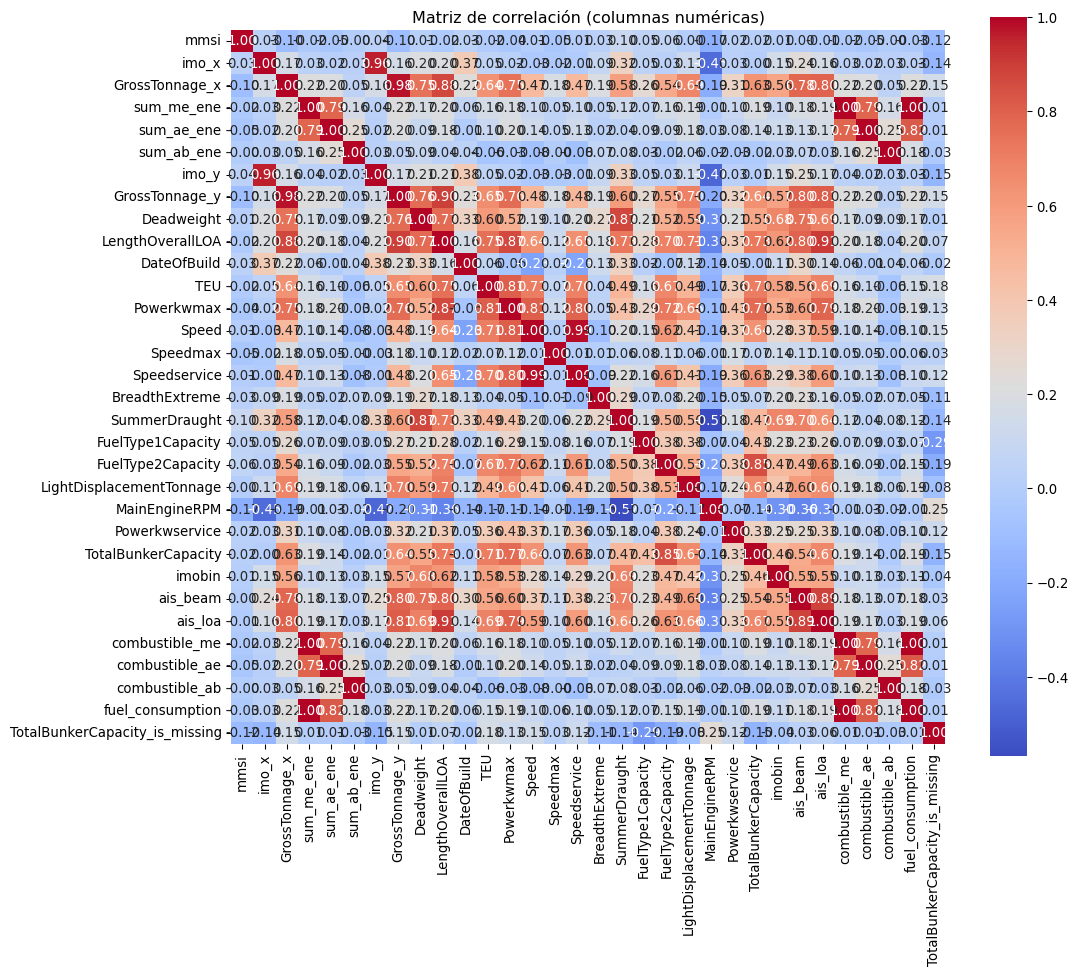

In [48]:
# Instancia: aplicar a X_train_int_imputado
corr_train = mostrar_matriz_correlacion(X_train_int_imputado)

### **Definición de la función para eliminar correlación alta**

In [49]:
#| label: eliminar_correlacion
#| warning: false
import numpy as np

# Función para elegir variables altamente correlacionadas
def choose_one_from_highly_correlated(correlation_matrix, threshold=0.60):
    """
    Identifica columnas a eliminar según correlación alta.
    
    Args:
        correlation_matrix (pd.DataFrame): matriz de correlación absoluta.
        threshold (float): umbral de correlación para eliminar variables.
    
    Returns:
        list: columnas a eliminar.
    """
    columns_to_remove = set()
    for column in correlation_matrix.columns:
        high_corr_columns = correlation_matrix[column][correlation_matrix[column] > threshold].index.tolist()
        if column in high_corr_columns:
            high_corr_columns.remove(column)
        if high_corr_columns:
            columns_to_remove.update(high_corr_columns[1:])
    return list(columns_to_remove)

### **Aplicación de la función a entrenamiento y validación**

In [50]:
#| label: aplicar_eliminar_correlacion
#| warning: false
import numpy as np

# Calcular matriz de correlación absoluta solo de columnas numéricas
correlation_matrix_train = X_train_int_imputado.select_dtypes(include=[np.number]).corr().abs()

# Identificar columnas a eliminar según correlación
columns_to_drop = choose_one_from_highly_correlated(correlation_matrix_train, threshold=0.60)

# Eliminar columnas de X_train_int y X_val_int
X_train_int_sin_corr = X_train_int_imputado.drop(columns=columns_to_drop)
X_val_int_sin_corr = X_val_int_imputado.drop(columns=columns_to_drop)

# Resumen
print(f"Columnas originales en train: {X_train_int_imputado.shape[1]}")
print(f"Columnas eliminadas por alta correlación: {len(columns_to_drop)}")
print(f"Columnas después de eliminación en train: {X_train_int_sin_corr.shape[1]}")

Columnas originales en train: 51
Columnas eliminadas por alta correlación: 18
Columnas después de eliminación en train: 33


# Aplicar la eliminación de columnas seleccionadas a train y validación

In [51]:
#| label: eliminar_variables
#| warning: false
# eliminar de train y validación usando la lista calculada
X_train_int_imputado = X_train_int_imputado.drop(columns=columns_to_drop)
X_val_int_imputado   = X_val_int_imputado.drop(columns=columns_to_drop)

## variables resultante

In [52]:
from tabulate import tabulate

# Crear lista de columnas y su tipo
variable_tipo = [(col, str(X_train_int_imputado[col].dtype)) for col in X_train_int_imputado.columns]

# Mostrar en formato tabla
print(tabulate(variable_tipo, headers=['Variable', 'Tipo'], tablefmt='grid'))

+--------------------------------+---------------------+
| Variable                       | Tipo                |
+================================+=====================+
| mmsi                           | int32               |
+--------------------------------+---------------------+
| start_leg                      | datetime64[ns, UTC] |
+--------------------------------+---------------------+
| end_leg                        | datetime64[ns, UTC] |
+--------------------------------+---------------------+
| h3_sequence                    | object              |
+--------------------------------+---------------------+
| imo_x                          | int32               |
+--------------------------------+---------------------+
| ref_in                         | datetime64[us]      |
+--------------------------------+---------------------+
| ref_out                        | datetime64[us]      |
+--------------------------------+---------------------+
| port_before                  

## outliers



## **Definir features numéricas y categóricas**

In [53]:
#| label: definir_features
#| warning: false
import pandas as pd

# Columnas numéricas que vamos a escalar

numeric_features = [
    'GrossTonnage_x', 'sum_me_ene', 'sum_ab_ene', 
    'Speedmax', 'BreadthExtreme', 'FuelType1Capacity', 
    'MainEngineRPM', 'Powerkwservice', 'combustible_ab', 
    'TotalBunkerCapacity_is_missing'
]


# Columnas categóricas (objetos) excluyendo h3_sequence
categorical_features = X_train_int_imputado.select_dtypes(include=['object']).columns.tolist()
if 'h3_sequence' in categorical_features:
    categorical_features.remove('h3_sequence')

print("Numéricas:", numeric_features)
print("Categóricas:", categorical_features)

Numéricas: ['GrossTonnage_x', 'sum_me_ene', 'sum_ab_ene', 'Speedmax', 'BreadthExtreme', 'FuelType1Capacity', 'MainEngineRPM', 'Powerkwservice', 'combustible_ab', 'TotalBunkerCapacity_is_missing']
Categóricas: ['port_before', 'country_before', 'port_after', 'country_after', 'op_phase', 'StandardVesselType_x', 'MainEngineModel', 'MainEngineType', 'PropulsionType', 'ShiptypeLevel5', 'StandardVesselType_y', 'fuel', 'meType']


## **Escalado de features numéricas y codificación de categóricas**


In [54]:
#| label: escalado_numerico
#| warning: false
# Escalado numérico
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = X_train_int_imputado.copy()
X_val_scaled = X_val_int_imputado.copy()

X_train_scaled[numeric_features] = scaler.fit_transform(X_train_scaled[numeric_features])
X_val_scaled[numeric_features] = scaler.transform(X_val_scaled[numeric_features])

print("Escalado numérico realizado ✅")

Escalado numérico realizado ✅


In [55]:
#| label: conversion_categoricas
#| warning: false
# Convertir todas las columnas categóricas a string (por si hay tipos mixtos)
X_train_scaled[categorical_features] = X_train_scaled[categorical_features].astype(str)
X_val_scaled[categorical_features] = X_val_scaled[categorical_features].astype(str)

print("Columnas categóricas convertidas a string ✅")

Columnas categóricas convertidas a string ✅

In [56]:
#| label: codificacion_onehot
#| warning: false
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Codificación one-hot
encoder = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
    remainder='drop'  # solo se procesan las columnas categóricas que definimos
)

X_train_enc = encoder.fit_transform(X_train_scaled)
X_val_enc = encoder.transform(X_val_scaled)

print("Codificación One-Hot realizada ✅")

Codificación One-Hot realizada ✅


In [57]:
#| label: conversion_dataframe
#| warning: false
# Convertimos a DataFrame para inspección
import pandas as pd

X_train_df = pd.DataFrame(X_train_enc.toarray() if hasattr(X_train_enc, "toarray") else X_train_enc)
X_val_df = pd.DataFrame(X_val_enc.toarray() if hasattr(X_val_enc, "toarray") else X_val_enc)

print("Conversión a DataFrame realizada ✅")
print("Dimensiones X_train_df:", X_train_df.shape)
print("Dimensiones X_val_df:", X_val_df.shape)

Conversión a DataFrame realizada ✅
Dimensiones X_train_df: (15312, 1364)
Dimensiones X_val_df: (3828, 1364)


In [58]:
#| label: verificacion_targuet
#| warning: false
print("NaN en y_train_int:", y_train_int.isna().sum())
print("NaN en y_val_int:", y_val_int.isna().sum())
print("Valores únicos en y_train_int:", y_train_int.unique())

NaN en y_train_int: 0


NaN en y_val_int: 0
Valores únicos en y_train_int: [2.47487183e+03 2.08071100e+01 7.57015043e+02 ... 1.39331007e+03
 1.60673185e+04 3.65883159e+04]


## **Escalado de la variable objetivo**

In [59]:
#| label: escalado_target
#| warning: false
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train_int.values.reshape(-1,1))
y_val_scaled = scaler_y.transform(y_val_int.values.reshape(-1,1))

## inspeccionar_target

In [60]:
#| label: verificar_y
#| warning: false
import numpy as np

print("NaN en y_train_scaled:", np.isnan(y_train_scaled).sum())
print("Inf en y_train_scaled:", np.isinf(y_train_scaled).sum())
print("NaN en y_val_scaled:", np.isnan(y_val_scaled).sum())
print("Inf en y_val_scaled:", np.isinf(y_val_scaled).sum())

print("Valores mínimos y máximos en y_train_scaled:", y_train_scaled.min(), y_train_scaled.max())
print("Valores mínimos y máximos en y_val_scaled:", y_val_scaled.min(), y_val_scaled.max())

NaN en y_train_scaled: 0
Inf en y_train_scaled: 0
NaN en y_val_scaled: 0
Inf en y_val_scaled: 0
Valores mínimos y máximos en y_train_scaled: 0.0 1.0000000000000002
Valores mínimos y máximos en y_val_scaled: -5.700627960199813e-09 1.2468833255578058


## **Crear secuencias para LSTM (con índices originales)**

In [61]:
#| label: crear_secuencias
#| warning: false
seq_len = 3

def create_sequences(X, y, df_indices, seq_len=3):
    X_seq, y_seq, idx_seq_all = [], [], []
    for _, group in df_indices.groupby('mmsi'):
        n = len(group)
        if n <= seq_len:
            continue
        for i in range(n - seq_len):
            idx_seq = group.index[i:i+seq_len].to_list()
            X_seq.append(X[idx_seq])
            y_seq.append(y[idx_seq[-1]])
            # Guardamos el índice real del último valor de la secuencia
            idx_seq_all.append(group.loc[idx_seq[-1], "index_original"])
    return np.array(X_seq), np.array(y_seq), np.array(idx_seq_all)

# Guardar índice original
X_train_scaled_reset = X_train_scaled.reset_index(drop=True)
X_train_scaled_reset['index_original'] = X_train_scaled_reset.index

X_val_scaled_reset = X_val_scaled.reset_index(drop=True)
X_val_scaled_reset['index_original'] = X_val_scaled_reset.index

# Crear secuencias
X_train_seq, y_train_seq, idx_train_seq = create_sequences(
    X_train_df.values, y_train_scaled, X_train_scaled_reset, seq_len
)
X_val_seq, y_val_seq, idx_val_seq = create_sequences(
    X_val_df.values, y_val_scaled, X_val_scaled_reset, seq_len
)

## **Construcción y entrenamiento del modelo LSTM**

In [62]:
#| label: entrenamiento_lstm
#| warning: false
#| output: false

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input

model = Sequential()
model.add(Input(shape=(seq_len, X_train_seq.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    verbose=1
)

Epoch 1/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 22:59 5s/step - loss: 0.0060 - mae: 0.0610

  5/290 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0064 - mae: 0.0607 

 10/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0069 - mae: 0.0630

 16/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0070 - mae: 0.0633

 22/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0069 - mae: 0.0625

 28/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0067 - mae: 0.0615

 34/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0066 - mae: 0.0605

 40/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0064 - mae: 0.0596

 46/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0063 - mae: 0.0588

 53/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0062 - mae: 0.0579

 60/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0060 - mae: 0.0571 

 66/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - mae: 0.0564

 72/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0059 - mae: 0.0558

 78/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0058 - mae: 0.0552

 84/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0057 - mae: 0.0546

 91/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0056 - mae: 0.0539

 98/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - mae: 0.0533

104/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - mae: 0.0527

110/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0053 - mae: 0.0522

116/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mae: 0.0517

123/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0052 - mae: 0.0511

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0051 - mae: 0.0506

135/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - mae: 0.0502

142/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mae: 0.0497

148/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0049 - mae: 0.0492

155/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mae: 0.0488

161/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - mae: 0.0484

167/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mae: 0.0480

174/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0047 - mae: 0.0476

181/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0472

187/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - mae: 0.0469

193/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0466

199/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - mae: 0.0463

206/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0459

213/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - mae: 0.0456

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0453

225/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0450

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - mae: 0.0448

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0445

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0442

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - mae: 0.0439

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0437

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0435

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - mae: 0.0433

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0431

284/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0428

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - mae: 0.0426

290/290 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0028 - mae: 0.0334 - val_loss: 9.6174e-04 - val_mae: 0.0173


Epoch 2/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 2.7321e-04 - mae: 0.0122

  6/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0012 - mae: 0.0206     

 11/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0213

 16/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0219

 21/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0222

 27/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0014 - mae: 0.0222

 34/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0014 - mae: 0.0221 

 41/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0221

 48/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0221

 54/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0221

 55/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0221

 56/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0221

 61/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0221

 67/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0221

 73/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0221

 79/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0013 - mae: 0.0221

 86/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0221

 92/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0013 - mae: 0.0221

 98/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0221

104/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0221

111/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0221

117/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0013 - mae: 0.0221

123/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

135/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

141/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

147/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

153/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

159/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

165/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

172/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

178/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0014 - mae: 0.0221

184/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0221 

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0221

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0221

199/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0221

205/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0222

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0222

217/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - mae: 0.0222

223/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222 

230/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

243/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

266/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0222

273/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0221

279/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0221

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0014 - mae: 0.0221

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0015 - mae: 0.0218 - val_loss: 8.4264e-04 - val_mae: 0.0167


Epoch 3/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 15s 53ms/step - loss: 0.0026 - mae: 0.0256

  7/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0016 - mae: 0.0216  

 13/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0013 - mae: 0.0206

 19/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0012 - mae: 0.0201

 25/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0197

 31/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0195

 37/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0010 - mae: 0.0193

 43/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0191

 49/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0191

 56/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0190

 62/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0011 - mae: 0.0189

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0189

 76/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0188

 83/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0188

 90/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0188

 96/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0188

102/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0187

108/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0187

114/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0187

120/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0011 - mae: 0.0186

128/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0186

136/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0185

143/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0185

149/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0185

156/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0184

163/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0184

169/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0010 - mae: 0.0183

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0183

181/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0183

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0183

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0182

202/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0182

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0182

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0182

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

234/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

242/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

248/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0181

261/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0180

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0180

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0180

282/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0180

289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0010 - mae: 0.0180

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0010 - mae: 0.0173 - val_loss: 5.5938e-04 - val_mae: 0.0133


Epoch 4/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 3.2615e-04 - mae: 0.0133

  6/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.9611e-04 - mae: 0.0152 

 12/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.6906e-04 - mae: 0.0147 

 18/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.7335e-04 - mae: 0.0145

 24/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.8071e-04 - mae: 0.0144

 30/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.0242e-04 - mae: 0.0144

 37/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.2460e-04 - mae: 0.0145

 44/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.4013e-04 - mae: 0.0145

 51/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.4955e-04 - mae: 0.0145

 57/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.5653e-04 - mae: 0.0145

 63/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6299e-04 - mae: 0.0146

 70/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.6931e-04 - mae: 0.0146

 76/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7376e-04 - mae: 0.0146

 83/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.7919e-04 - mae: 0.0147

 89/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.8313e-04 - mae: 0.0147

 96/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.8677e-04 - mae: 0.0147

101/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8863e-04 - mae: 0.0147

105/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.8958e-04 - mae: 0.0147

111/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9052e-04 - mae: 0.0147

117/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9334e-04 - mae: 0.0147

123/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9537e-04 - mae: 0.0147

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9660e-04 - mae: 0.0147

135/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9762e-04 - mae: 0.0147

141/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9821e-04 - mae: 0.0147

147/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9821e-04 - mae: 0.0147

153/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9818e-04 - mae: 0.0147

159/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.9789e-04 - mae: 0.0147

165/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9743e-04 - mae: 0.0147 

172/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9679e-04 - mae: 0.0146

178/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.9599e-04 - mae: 0.0146

185/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9476e-04 - mae: 0.0146

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9364e-04 - mae: 0.0146

197/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9255e-04 - mae: 0.0146

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9114e-04 - mae: 0.0145

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9008e-04 - mae: 0.0145

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8934e-04 - mae: 0.0145

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8902e-04 - mae: 0.0145

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8869e-04 - mae: 0.0145

235/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8845e-04 - mae: 0.0144

242/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8839e-04 - mae: 0.0144

248/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8980e-04 - mae: 0.0144

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9164e-04 - mae: 0.0144

262/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9364e-04 - mae: 0.0144

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9548e-04 - mae: 0.0144

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9782e-04 - mae: 0.0144

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9995e-04 - mae: 0.0144

287/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0196e-04 - mae: 0.0144

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 6.9578e-04 - mae: 0.0140 - val_loss: 4.5261e-04 - val_mae: 0.0112


Epoch 5/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - loss: 2.1146e-04 - mae: 0.0104

  7/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4506e-04 - mae: 0.0122  

 14/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4256e-04 - mae: 0.0120

 20/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4512e-04 - mae: 0.0119

 27/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6261e-04 - mae: 0.0119

 33/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7462e-04 - mae: 0.0120

 39/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8070e-04 - mae: 0.0120

 45/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.9318e-04 - mae: 0.0120

 51/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.0210e-04 - mae: 0.0120

 58/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.1174e-04 - mae: 0.0120

 60/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.1356e-04 - mae: 0.0120

 66/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.1736e-04 - mae: 0.0120

 72/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.2142e-04 - mae: 0.0120

 78/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.2566e-04 - mae: 0.0120

 85/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.3398e-04 - mae: 0.0121

 91/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4148e-04 - mae: 0.0121

 97/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5004e-04 - mae: 0.0121

103/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5675e-04 - mae: 0.0121

109/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6196e-04 - mae: 0.0121

115/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6713e-04 - mae: 0.0122

122/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7183e-04 - mae: 0.0122

128/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7497e-04 - mae: 0.0122

134/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7768e-04 - mae: 0.0122

140/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8015e-04 - mae: 0.0122

147/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8354e-04 - mae: 0.0122

154/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.8704e-04 - mae: 0.0122

161/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.9017e-04 - mae: 0.0122

168/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9307e-04 - mae: 0.0122 

174/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9541e-04 - mae: 0.0122

180/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 4.9835e-04 - mae: 0.0122

186/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0109e-04 - mae: 0.0122

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0382e-04 - mae: 0.0122

198/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0627e-04 - mae: 0.0122

205/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.0874e-04 - mae: 0.0122

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1069e-04 - mae: 0.0122

217/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1236e-04 - mae: 0.0122

224/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1397e-04 - mae: 0.0122

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1559e-04 - mae: 0.0123

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1712e-04 - mae: 0.0123

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.1860e-04 - mae: 0.0123

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2001e-04 - mae: 0.0123

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2123e-04 - mae: 0.0123

265/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2361e-04 - mae: 0.0123

272/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2570e-04 - mae: 0.0123

278/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2738e-04 - mae: 0.0123

284/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.2901e-04 - mae: 0.0123

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 5.9939e-04 - mae: 0.0122 - val_loss: 3.9564e-04 - val_mae: 0.0094


Epoch 6/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 1.2174e-04 - mae: 0.0087

  6/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.4384e-04 - mae: 0.0087 

 13/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8283e-04 - mae: 0.0087 

 20/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.1507e-04 - mae: 0.0089

 27/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.3489e-04 - mae: 0.0091

 33/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4595e-04 - mae: 0.0093

 39/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.5856e-04 - mae: 0.0093

 45/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7703e-04 - mae: 0.0094

 51/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9306e-04 - mae: 0.0095

 58/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0650e-04 - mae: 0.0096

 64/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.1623e-04 - mae: 0.0096

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2259e-04 - mae: 0.0097

 75/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2809e-04 - mae: 0.0097

 81/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3264e-04 - mae: 0.0098

 88/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3722e-04 - mae: 0.0098

 94/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4079e-04 - mae: 0.0098

101/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4399e-04 - mae: 0.0098

108/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4608e-04 - mae: 0.0098

112/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4722e-04 - mae: 0.0098

117/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4900e-04 - mae: 0.0098

124/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5140e-04 - mae: 0.0099

130/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5345e-04 - mae: 0.0099

136/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5489e-04 - mae: 0.0099

141/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5576e-04 - mae: 0.0099

148/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5724e-04 - mae: 0.0099

155/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.5952e-04 - mae: 0.0099

161/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6198e-04 - mae: 0.0099

167/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6427e-04 - mae: 0.0099

173/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.6636e-04 - mae: 0.0099

179/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6832e-04 - mae: 0.0099 

185/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7043e-04 - mae: 0.0099

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7294e-04 - mae: 0.0099

198/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7596e-04 - mae: 0.0099

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7848e-04 - mae: 0.0099

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8082e-04 - mae: 0.0100

217/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8360e-04 - mae: 0.0100

224/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8610e-04 - mae: 0.0100

230/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8804e-04 - mae: 0.0100

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9108e-04 - mae: 0.0100

243/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9355e-04 - mae: 0.0100

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9589e-04 - mae: 0.0100

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.9808e-04 - mae: 0.0100

262/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0040e-04 - mae: 0.0100

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0224e-04 - mae: 0.0100

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0432e-04 - mae: 0.0100

282/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0622e-04 - mae: 0.0101

289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0793e-04 - mae: 0.0101

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 4.7483e-04 - mae: 0.0105 - val_loss: 3.6114e-04 - val_mae: 0.0079


Epoch 7/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 18s 64ms/step - loss: 1.9802e-04 - mae: 0.0092

  7/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8002e-04 - mae: 0.0084  

  8/290 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1.7655e-04 - mae: 0.0083

 13/290 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 1.8034e-04 - mae: 0.0083

 17/290 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 1.9157e-04 - mae: 0.0083

 23/290 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 2.0016e-04 - mae: 0.0084

 29/290 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 2.0653e-04 - mae: 0.0084

 35/290 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 2.2148e-04 - mae: 0.0085

 41/290 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4030e-04 - mae: 0.0086

 47/290 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.5627e-04 - mae: 0.0087

 53/290 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.6823e-04 - mae: 0.0088

 59/290 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.8155e-04 - mae: 0.0089

 66/290 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 2.9329e-04 - mae: 0.0090

 72/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0024e-04 - mae: 0.0090

 78/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0557e-04 - mae: 0.0091

 84/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.0982e-04 - mae: 0.0091

 90/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1319e-04 - mae: 0.0091

 97/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1633e-04 - mae: 0.0092

104/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1868e-04 - mae: 0.0092

111/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2181e-04 - mae: 0.0092

119/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2509e-04 - mae: 0.0092

125/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2711e-04 - mae: 0.0092

131/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2878e-04 - mae: 0.0093

137/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3000e-04 - mae: 0.0093

141/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3109e-04 - mae: 0.0093

146/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3218e-04 - mae: 0.0093

153/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3360e-04 - mae: 0.0093

160/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3463e-04 - mae: 0.0093

167/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3589e-04 - mae: 0.0093

174/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3731e-04 - mae: 0.0093

181/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.3887e-04 - mae: 0.0093

187/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.4007e-04 - mae: 0.0093

190/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4058e-04 - mae: 0.0093

195/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.4157e-04 - mae: 0.0093

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4284e-04 - mae: 0.0093

206/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4480e-04 - mae: 0.0093

212/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4781e-04 - mae: 0.0093

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5151e-04 - mae: 0.0094

226/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5477e-04 - mae: 0.0094

233/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5786e-04 - mae: 0.0094

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6047e-04 - mae: 0.0094

240/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6087e-04 - mae: 0.0094

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6304e-04 - mae: 0.0094

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6633e-04 - mae: 0.0094

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6899e-04 - mae: 0.0094

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7149e-04 - mae: 0.0094

271/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7422e-04 - mae: 0.0094

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7634e-04 - mae: 0.0094

283/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7828e-04 - mae: 0.0095

289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.8004e-04 - mae: 0.0095

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.6131e-04 - mae: 0.0098 - val_loss: 3.0255e-04 - val_mae: 0.0077


Epoch 8/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - loss: 2.1584e-04 - mae: 0.0091

  7/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3677e-04 - mae: 0.0087 

 14/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7721e-04 - mae: 0.0086 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.7628e-04 - mae: 0.0089

 22/290 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 3.8446e-04 - mae: 0.0090

 26/290 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 4.0520e-04 - mae: 0.0091

 32/290 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 4.2426e-04 - mae: 0.0092

 38/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 4.3446e-04 - mae: 0.0093

 45/290 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.4131e-04 - mae: 0.0094

 52/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4385e-04 - mae: 0.0094

 59/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4320e-04 - mae: 0.0094

 66/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4052e-04 - mae: 0.0094

 72/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4125e-04 - mae: 0.0094

 79/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.4264e-04 - mae: 0.0094

 82/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4290e-04 - mae: 0.0094

 87/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4349e-04 - mae: 0.0094

 94/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4345e-04 - mae: 0.0094

101/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 4.4342e-04 - mae: 0.0094

108/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.4594e-04 - mae: 0.0094

114/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5103e-04 - mae: 0.0095

120/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.5589e-04 - mae: 0.0095

126/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5989e-04 - mae: 0.0095

132/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6320e-04 - mae: 0.0095

137/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6554e-04 - mae: 0.0095

143/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.6815e-04 - mae: 0.0095

150/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7032e-04 - mae: 0.0095

157/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7224e-04 - mae: 0.0095

163/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7390e-04 - mae: 0.0095

169/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7593e-04 - mae: 0.0096

175/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7744e-04 - mae: 0.0096

182/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.7902e-04 - mae: 0.0096

186/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.7975e-04 - mae: 0.0096

191/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8052e-04 - mae: 0.0096

198/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.8128e-04 - mae: 0.0096

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8167e-04 - mae: 0.0096

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8196e-04 - mae: 0.0096

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8201e-04 - mae: 0.0096

225/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8196e-04 - mae: 0.0096

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.8168e-04 - mae: 0.0096

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8131e-04 - mae: 0.0096

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.8072e-04 - mae: 0.0096

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.7988e-04 - mae: 0.0096

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7963e-04 - mae: 0.0096

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7895e-04 - mae: 0.0096

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7790e-04 - mae: 0.0096

274/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7674e-04 - mae: 0.0096

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7567e-04 - mae: 0.0096

287/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 4.7432e-04 - mae: 0.0096

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 4.1749e-04 - mae: 0.0093 - val_loss: 2.7658e-04 - val_mae: 0.0071


Epoch 9/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 13s 48ms/step - loss: 8.3404e-04 - mae: 0.0134

  6/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.6569e-04 - mae: 0.0107 

 11/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 4.8508e-04 - mae: 0.0097

 18/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.1190e-04 - mae: 0.0090 

 24/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.8212e-04 - mae: 0.0088

 31/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.6378e-04 - mae: 0.0086

 37/290 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 3.5255e-04 - mae: 0.0085

 42/290 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.4937e-04 - mae: 0.0085

 49/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.4302e-04 - mae: 0.0084

 57/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.3706e-04 - mae: 0.0084

 64/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.3240e-04 - mae: 0.0084

 70/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.2883e-04 - mae: 0.0084

 76/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.2501e-04 - mae: 0.0084

 83/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3.2135e-04 - mae: 0.0084

 90/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1868e-04 - mae: 0.0084

 95/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1673e-04 - mae: 0.0084

100/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1632e-04 - mae: 0.0084

106/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 3.1825e-04 - mae: 0.0084

112/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.1962e-04 - mae: 0.0084

118/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2055e-04 - mae: 0.0084

124/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2203e-04 - mae: 0.0084

132/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2420e-04 - mae: 0.0084

139/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2556e-04 - mae: 0.0084

145/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.2639e-04 - mae: 0.0084

151/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2702e-04 - mae: 0.0084

156/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2736e-04 - mae: 0.0084

162/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.2872e-04 - mae: 0.0084

169/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3021e-04 - mae: 0.0084

175/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3141e-04 - mae: 0.0084

182/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3283e-04 - mae: 0.0084

189/290 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.3396e-04 - mae: 0.0084

196/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3479e-04 - mae: 0.0084

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3540e-04 - mae: 0.0084

205/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3555e-04 - mae: 0.0084

206/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3562e-04 - mae: 0.0084

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3587e-04 - mae: 0.0084

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3611e-04 - mae: 0.0084

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3627e-04 - mae: 0.0084

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3632e-04 - mae: 0.0085

236/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3634e-04 - mae: 0.0085

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3634e-04 - mae: 0.0085

246/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3635e-04 - mae: 0.0085

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3631e-04 - mae: 0.0085

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3635e-04 - mae: 0.0085

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3632e-04 - mae: 0.0085

271/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3643e-04 - mae: 0.0085

278/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3663e-04 - mae: 0.0085

284/290 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.3671e-04 - mae: 0.0085

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3671e-04 - mae: 0.0085

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 3.3505e-04 - mae: 0.0084 - val_loss: 3.0480e-04 - val_mae: 0.0073


Epoch 10/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - loss: 4.5028e-05 - mae: 0.0056

  8/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.4638e-04 - mae: 0.0072  

 14/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8991e-04 - mae: 0.0074

 21/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.2250e-04 - mae: 0.0077

 27/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.4253e-04 - mae: 0.0079

 34/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.6838e-04 - mae: 0.0081

 40/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8141e-04 - mae: 0.0082

 46/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8811e-04 - mae: 0.0083

 53/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9127e-04 - mae: 0.0083

 59/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9105e-04 - mae: 0.0083

 65/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.9023e-04 - mae: 0.0083

 71/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8884e-04 - mae: 0.0083

 77/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8682e-04 - mae: 0.0083

 84/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8402e-04 - mae: 0.0083

 92/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8200e-04 - mae: 0.0082

 99/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8097e-04 - mae: 0.0082

106/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8143e-04 - mae: 0.0082

112/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8150e-04 - mae: 0.0082

118/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8271e-04 - mae: 0.0082

125/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8430e-04 - mae: 0.0082

132/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8556e-04 - mae: 0.0082

139/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8677e-04 - mae: 0.0082

147/290 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.8745e-04 - mae: 0.0082

154/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8802e-04 - mae: 0.0082

161/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8873e-04 - mae: 0.0082

167/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8925e-04 - mae: 0.0082

173/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8963e-04 - mae: 0.0082

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8985e-04 - mae: 0.0082

185/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8999e-04 - mae: 0.0082

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9013e-04 - mae: 0.0082

198/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.9012e-04 - mae: 0.0082

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8995e-04 - mae: 0.0082

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8971e-04 - mae: 0.0082

217/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8931e-04 - mae: 0.0082

224/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8892e-04 - mae: 0.0082

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8884e-04 - mae: 0.0082

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8880e-04 - mae: 0.0082

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8874e-04 - mae: 0.0082

250/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8866e-04 - mae: 0.0082

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8854e-04 - mae: 0.0082

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8829e-04 - mae: 0.0082

269/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8807e-04 - mae: 0.0082

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8785e-04 - mae: 0.0082

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8768e-04 - mae: 0.0082

287/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8750e-04 - mae: 0.0081

290/290 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7882e-04 - mae: 0.0080 - val_loss: 2.8541e-04 - val_mae: 0.0071


Epoch 11/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - loss: 3.9499e-05 - mae: 0.0045

  7/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.2212e-05 - mae: 0.0059  

 14/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.8911e-04 - mae: 0.0067

 20/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.6545e-04 - mae: 0.0070

 26/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8598e-04 - mae: 0.0071

 32/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8943e-04 - mae: 0.0071

 41/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.8602e-04 - mae: 0.0070

 46/290 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8262e-04 - mae: 0.0070

 50/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7961e-04 - mae: 0.0070

 54/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7708e-04 - mae: 0.0070

 60/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.7272e-04 - mae: 0.0070

 66/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6841e-04 - mae: 0.0070

 72/290 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 2.6439e-04 - mae: 0.0070

 78/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.6025e-04 - mae: 0.0070

 85/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5705e-04 - mae: 0.0069

 91/290 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.5465e-04 - mae: 0.0069

 97/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5285e-04 - mae: 0.0069

103/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5130e-04 - mae: 0.0070

110/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5049e-04 - mae: 0.0070

116/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5044e-04 - mae: 0.0070

121/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5042e-04 - mae: 0.0070

127/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5022e-04 - mae: 0.0070

134/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5028e-04 - mae: 0.0070

141/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5062e-04 - mae: 0.0070

147/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5114e-04 - mae: 0.0070

152/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5139e-04 - mae: 0.0070

154/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5143e-04 - mae: 0.0070

161/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5211e-04 - mae: 0.0070

171/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5375e-04 - mae: 0.0071

182/290 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 2.5536e-04 - mae: 0.0071

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5660e-04 - mae: 0.0071 

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5797e-04 - mae: 0.0071

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5895e-04 - mae: 0.0071

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6018e-04 - mae: 0.0071

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.6110e-04 - mae: 0.0071

248/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6171e-04 - mae: 0.0071

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6221e-04 - mae: 0.0071

269/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6282e-04 - mae: 0.0071

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6331e-04 - mae: 0.0072

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.7617e-04 - mae: 0.0074 - val_loss: 3.0630e-04 - val_mae: 0.0066


Epoch 12/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 1.1063e-04 - mae: 0.0054

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1177e-04 - mae: 0.0060 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3220e-04 - mae: 0.0061

 31/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3648e-04 - mae: 0.0061

 42/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4549e-04 - mae: 0.0062

 51/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6390e-04 - mae: 0.0063

 60/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7538e-04 - mae: 0.0064

 64/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7999e-04 - mae: 0.0064

 72/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8666e-04 - mae: 0.0065

 79/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9400e-04 - mae: 0.0065

 84/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0012e-04 - mae: 0.0066

 91/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0701e-04 - mae: 0.0066

100/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1406e-04 - mae: 0.0067

110/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2102e-04 - mae: 0.0067

120/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2688e-04 - mae: 0.0068

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3152e-04 - mae: 0.0069

138/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.3530e-04 - mae: 0.0069

147/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3857e-04 - mae: 0.0070

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4113e-04 - mae: 0.0070

169/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4311e-04 - mae: 0.0070

180/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4432e-04 - mae: 0.0071

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4515e-04 - mae: 0.0071

200/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4592e-04 - mae: 0.0071

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4748e-04 - mae: 0.0071

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4971e-04 - mae: 0.0072

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.4993e-04 - mae: 0.0072

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5184e-04 - mae: 0.0072

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5331e-04 - mae: 0.0072

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5482e-04 - mae: 0.0072

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5635e-04 - mae: 0.0072

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5775e-04 - mae: 0.0073

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5902e-04 - mae: 0.0073

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 2.8694e-04 - mae: 0.0076 - val_loss: 2.8498e-04 - val_mae: 0.0077


Epoch 13/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.2619e-04 - mae: 0.0079

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9721e-04 - mae: 0.0080 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9349e-04 - mae: 0.0078

 31/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9326e-04 - mae: 0.0076

 41/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9198e-04 - mae: 0.0075

 51/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9005e-04 - mae: 0.0075

 62/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8965e-04 - mae: 0.0074

 68/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8874e-04 - mae: 0.0074

 77/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8734e-04 - mae: 0.0073

 86/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8686e-04 - mae: 0.0073

 96/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8825e-04 - mae: 0.0073

105/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8931e-04 - mae: 0.0073

115/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9063e-04 - mae: 0.0072

125/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9163e-04 - mae: 0.0072

135/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9200e-04 - mae: 0.0072

147/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9186e-04 - mae: 0.0072

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9158e-04 - mae: 0.0072

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9226e-04 - mae: 0.0072

178/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9426e-04 - mae: 0.0072

187/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9554e-04 - mae: 0.0071

198/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9670e-04 - mae: 0.0071

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9750e-04 - mae: 0.0071

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9812e-04 - mae: 0.0071

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9850e-04 - mae: 0.0071

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9871e-04 - mae: 0.0071

247/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9878e-04 - mae: 0.0071

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9878e-04 - mae: 0.0071

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9878e-04 - mae: 0.0071

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9883e-04 - mae: 0.0071

283/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9885e-04 - mae: 0.0071

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.0988e-04 - mae: 0.0071 - val_loss: 2.6345e-04 - val_mae: 0.0061


Epoch 14/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 1.2617e-04 - mae: 0.0070

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2208e-04 - mae: 0.0074  

 19/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9329e-04 - mae: 0.0072

 26/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9156e-04 - mae: 0.0072

 33/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8924e-04 - mae: 0.0072

 43/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0768e-04 - mae: 0.0073

 53/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2988e-04 - mae: 0.0074

 62/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4286e-04 - mae: 0.0075

 71/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.4953e-04 - mae: 0.0075

 80/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5365e-04 - mae: 0.0075

 89/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5559e-04 - mae: 0.0075

 97/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5619e-04 - mae: 0.0075

106/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5619e-04 - mae: 0.0075

115/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.5540e-04 - mae: 0.0075

124/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5498e-04 - mae: 0.0075

133/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5441e-04 - mae: 0.0075

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5370e-04 - mae: 0.0075

153/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5280e-04 - mae: 0.0075

163/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5239e-04 - mae: 0.0075

173/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5221e-04 - mae: 0.0074

183/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5181e-04 - mae: 0.0074

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5106e-04 - mae: 0.0074

200/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5052e-04 - mae: 0.0074

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4949e-04 - mae: 0.0074

220/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4834e-04 - mae: 0.0074

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4726e-04 - mae: 0.0074

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4688e-04 - mae: 0.0074

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4660e-04 - mae: 0.0074

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4618e-04 - mae: 0.0073

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4587e-04 - mae: 0.0073

279/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4548e-04 - mae: 0.0073

288/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4511e-04 - mae: 0.0073

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2.3298e-04 - mae: 0.0071 - val_loss: 2.5935e-04 - val_mae: 0.0061


Epoch 15/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 2.5548e-04 - mae: 0.0071

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5051e-04 - mae: 0.0062  

 20/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2709e-04 - mae: 0.0060

 26/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2698e-04 - mae: 0.0061

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2668e-04 - mae: 0.0061

 41/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.2741e-04 - mae: 0.0062

 50/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2737e-04 - mae: 0.0062

 59/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2723e-04 - mae: 0.0062

 68/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2764e-04 - mae: 0.0062

 78/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2962e-04 - mae: 0.0062

 88/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3136e-04 - mae: 0.0062

 98/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3307e-04 - mae: 0.0063

105/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3386e-04 - mae: 0.0063

112/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3468e-04 - mae: 0.0063

120/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3581e-04 - mae: 0.0063

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3771e-04 - mae: 0.0063

139/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4055e-04 - mae: 0.0063

146/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4301e-04 - mae: 0.0064

154/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4538e-04 - mae: 0.0064

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4832e-04 - mae: 0.0064

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5152e-04 - mae: 0.0064

186/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5467e-04 - mae: 0.0064

196/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5711e-04 - mae: 0.0064

206/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5907e-04 - mae: 0.0065

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6125e-04 - mae: 0.0065

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6370e-04 - mae: 0.0065

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6556e-04 - mae: 0.0065

246/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6701e-04 - mae: 0.0065

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6835e-04 - mae: 0.0065

266/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6968e-04 - mae: 0.0065

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7016e-04 - mae: 0.0065

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7083e-04 - mae: 0.0065

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7134e-04 - mae: 0.0065

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.7213e-04 - mae: 0.0065

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.9543e-04 - mae: 0.0066 - val_loss: 2.5185e-04 - val_mae: 0.0060


Epoch 16/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 1.4138e-04 - mae: 0.0066

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.9663e-04 - mae: 0.0069 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7523e-04 - mae: 0.0068

 33/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.5129e-04 - mae: 0.0067

 44/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.3472e-04 - mae: 0.0066

 55/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2635e-04 - mae: 0.0066

 66/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1891e-04 - mae: 0.0066

 77/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.1331e-04 - mae: 0.0065

 88/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0895e-04 - mae: 0.0065

 99/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0512e-04 - mae: 0.0065

110/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0203e-04 - mae: 0.0065

121/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9988e-04 - mae: 0.0065

133/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9914e-04 - mae: 0.0064

144/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9888e-04 - mae: 0.0064

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9848e-04 - mae: 0.0064

166/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9803e-04 - mae: 0.0064

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9731e-04 - mae: 0.0064

189/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9655e-04 - mae: 0.0064

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9571e-04 - mae: 0.0064

213/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9524e-04 - mae: 0.0064

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9496e-04 - mae: 0.0064

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9464e-04 - mae: 0.0064

243/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9423e-04 - mae: 0.0064

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9376e-04 - mae: 0.0064

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9340e-04 - mae: 0.0064

274/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9318e-04 - mae: 0.0064

286/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9299e-04 - mae: 0.0064

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.8725e-04 - mae: 0.0064 - val_loss: 3.0625e-04 - val_mae: 0.0067


Epoch 17/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1.0724e-04 - mae: 0.0056

 13/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0075e-04 - mae: 0.0057 

 25/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2684e-04 - mae: 0.0061

 37/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3387e-04 - mae: 0.0062

 49/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3504e-04 - mae: 0.0061

 60/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3535e-04 - mae: 0.0061

 72/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3387e-04 - mae: 0.0061

 83/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3321e-04 - mae: 0.0061

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3279e-04 - mae: 0.0061

105/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3291e-04 - mae: 0.0061

116/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3300e-04 - mae: 0.0061

127/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3366e-04 - mae: 0.0061

138/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3411e-04 - mae: 0.0061

149/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3552e-04 - mae: 0.0061

160/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3728e-04 - mae: 0.0061

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3900e-04 - mae: 0.0061

182/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4055e-04 - mae: 0.0061

193/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4199e-04 - mae: 0.0061

202/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4368e-04 - mae: 0.0061

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4505e-04 - mae: 0.0061

220/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4652e-04 - mae: 0.0061

230/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4792e-04 - mae: 0.0062

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4926e-04 - mae: 0.0062

251/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5033e-04 - mae: 0.0062

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5115e-04 - mae: 0.0062

269/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5189e-04 - mae: 0.0062

279/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5275e-04 - mae: 0.0062

287/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5338e-04 - mae: 0.0062

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7812e-04 - mae: 0.0063 - val_loss: 2.9357e-04 - val_mae: 0.0063


Epoch 18/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 5.2012e-05 - mae: 0.0052

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1559e-05 - mae: 0.0064 

 19/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0598e-04 - mae: 0.0062

 29/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2660e-04 - mae: 0.0062

 38/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3984e-04 - mae: 0.0062

 48/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5399e-04 - mae: 0.0062

 56/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6579e-04 - mae: 0.0062

 63/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7402e-04 - mae: 0.0062

 71/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7957e-04 - mae: 0.0063

 80/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8327e-04 - mae: 0.0063

 87/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8571e-04 - mae: 0.0063

 95/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8727e-04 - mae: 0.0063

103/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9002e-04 - mae: 0.0063

112/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9283e-04 - mae: 0.0063

122/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9540e-04 - mae: 0.0063

135/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9739e-04 - mae: 0.0063

146/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9812e-04 - mae: 0.0063

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9833e-04 - mae: 0.0063

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9835e-04 - mae: 0.0063

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9909e-04 - mae: 0.0063

186/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9986e-04 - mae: 0.0063

197/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0062e-04 - mae: 0.0063

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0101e-04 - mae: 0.0063

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0115e-04 - mae: 0.0063

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0107e-04 - mae: 0.0063

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0072e-04 - mae: 0.0063

248/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0034e-04 - mae: 0.0063

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9992e-04 - mae: 0.0063

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9938e-04 - mae: 0.0063

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9883e-04 - mae: 0.0063

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9832e-04 - mae: 0.0063

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8161e-04 - mae: 0.0062 - val_loss: 3.1200e-04 - val_mae: 0.0068


Epoch 19/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 3.3955e-04 - mae: 0.0102

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7406e-04 - mae: 0.0071 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7723e-04 - mae: 0.0068

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6969e-04 - mae: 0.0066

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6667e-04 - mae: 0.0064

 55/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6266e-04 - mae: 0.0064

 66/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5776e-04 - mae: 0.0063

 77/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5414e-04 - mae: 0.0062

 88/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5548e-04 - mae: 0.0061

100/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5616e-04 - mae: 0.0061

112/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5612e-04 - mae: 0.0061

125/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5608e-04 - mae: 0.0060

137/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5574e-04 - mae: 0.0060

147/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5510e-04 - mae: 0.0060

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5466e-04 - mae: 0.0060

166/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5428e-04 - mae: 0.0060

176/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5370e-04 - mae: 0.0060

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5309e-04 - mae: 0.0059

199/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5245e-04 - mae: 0.0059

210/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5198e-04 - mae: 0.0059

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5164e-04 - mae: 0.0059

233/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5138e-04 - mae: 0.0059

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5141e-04 - mae: 0.0059

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5169e-04 - mae: 0.0059

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5187e-04 - mae: 0.0059

279/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5219e-04 - mae: 0.0059

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5281e-04 - mae: 0.0059

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6777e-04 - mae: 0.0061 - val_loss: 2.6126e-04 - val_mae: 0.0059


Epoch 20/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 5.0448e-05 - mae: 0.0045

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6241e-05 - mae: 0.0050  

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3419e-05 - mae: 0.0052

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.4587e-05 - mae: 0.0053

 44/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0189e-04 - mae: 0.0054

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0747e-04 - mae: 0.0055

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1206e-04 - mae: 0.0055

 81/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1475e-04 - mae: 0.0056

 93/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1624e-04 - mae: 0.0056

105/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1724e-04 - mae: 0.0056

116/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1849e-04 - mae: 0.0056

128/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1963e-04 - mae: 0.0056

140/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2076e-04 - mae: 0.0056

152/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2231e-04 - mae: 0.0056

162/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2342e-04 - mae: 0.0056

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2429e-04 - mae: 0.0056

182/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2541e-04 - mae: 0.0056

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2661e-04 - mae: 0.0057

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2804e-04 - mae: 0.0057

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2944e-04 - mae: 0.0057

225/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3063e-04 - mae: 0.0057

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3207e-04 - mae: 0.0057

251/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3334e-04 - mae: 0.0057

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3439e-04 - mae: 0.0057

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3523e-04 - mae: 0.0057

286/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3601e-04 - mae: 0.0057

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5400e-04 - mae: 0.0058 - val_loss: 2.9726e-04 - val_mae: 0.0062


Epoch 21/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.4415e-04 - mae: 0.0053

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4088e-04 - mae: 0.0059 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4467e-04 - mae: 0.0058

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5128e-04 - mae: 0.0059

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5277e-04 - mae: 0.0060

 59/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5365e-04 - mae: 0.0061

 72/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5311e-04 - mae: 0.0061

 84/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5229e-04 - mae: 0.0061

 97/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5088e-04 - mae: 0.0061

110/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4928e-04 - mae: 0.0061

122/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4848e-04 - mae: 0.0061

133/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4818e-04 - mae: 0.0061

145/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4760e-04 - mae: 0.0061

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4710e-04 - mae: 0.0061

169/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4651e-04 - mae: 0.0061

181/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4573e-04 - mae: 0.0061

193/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4504e-04 - mae: 0.0061

205/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4543e-04 - mae: 0.0061

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4582e-04 - mae: 0.0061

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4652e-04 - mae: 0.0061

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4702e-04 - mae: 0.0061

257/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4760e-04 - mae: 0.0061

269/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4799e-04 - mae: 0.0061

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4830e-04 - mae: 0.0061

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5825e-04 - mae: 0.0061 - val_loss: 2.8425e-04 - val_mae: 0.0062


Epoch 22/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 8.5415e-05 - mae: 0.0054

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1034e-04 - mae: 0.0059 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0883e-04 - mae: 0.0057

 35/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1522e-04 - mae: 0.0056

 47/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3496e-04 - mae: 0.0056

 58/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4559e-04 - mae: 0.0057

 70/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5187e-04 - mae: 0.0057

 82/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5629e-04 - mae: 0.0057

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6020e-04 - mae: 0.0058

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6341e-04 - mae: 0.0058

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6548e-04 - mae: 0.0058

132/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6638e-04 - mae: 0.0059

144/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6675e-04 - mae: 0.0059

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6664e-04 - mae: 0.0059

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6621e-04 - mae: 0.0059

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6549e-04 - mae: 0.0059

190/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6526e-04 - mae: 0.0059

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6501e-04 - mae: 0.0059

215/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6485e-04 - mae: 0.0059

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6470e-04 - mae: 0.0059

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6451e-04 - mae: 0.0059

251/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6447e-04 - mae: 0.0059

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6439e-04 - mae: 0.0059

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6454e-04 - mae: 0.0059

287/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6493e-04 - mae: 0.0059

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7100e-04 - mae: 0.0060 - val_loss: 2.8401e-04 - val_mae: 0.0067


Epoch 23/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 4.5537e-05 - mae: 0.0046

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5491e-05 - mae: 0.0050 

 24/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7156e-05 - mae: 0.0049

 35/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1948e-04 - mae: 0.0051

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5359e-04 - mae: 0.0053

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7004e-04 - mae: 0.0055

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7968e-04 - mae: 0.0056

 81/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8443e-04 - mae: 0.0057

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8716e-04 - mae: 0.0058

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8761e-04 - mae: 0.0058

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8661e-04 - mae: 0.0058

130/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8516e-04 - mae: 0.0058

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8289e-04 - mae: 0.0058

156/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8075e-04 - mae: 0.0058

168/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7880e-04 - mae: 0.0058

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7722e-04 - mae: 0.0058

189/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7581e-04 - mae: 0.0058

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7432e-04 - mae: 0.0058

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7281e-04 - mae: 0.0058

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7143e-04 - mae: 0.0058

240/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7014e-04 - mae: 0.0058

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6898e-04 - mae: 0.0058

265/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6837e-04 - mae: 0.0058

278/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6810e-04 - mae: 0.0058

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6278e-04 - mae: 0.0058 - val_loss: 2.8397e-04 - val_mae: 0.0073


Epoch 24/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 8.1615e-05 - mae: 0.0058

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.3096e-04 - mae: 0.0071 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.7895e-04 - mae: 0.0068

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.4226e-04 - mae: 0.0066

 44/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2134e-04 - mae: 0.0064

 56/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0271e-04 - mae: 0.0062

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8836e-04 - mae: 0.0061

 81/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8176e-04 - mae: 0.0060

 92/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7789e-04 - mae: 0.0060

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7433e-04 - mae: 0.0059

118/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7206e-04 - mae: 0.0059

131/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7163e-04 - mae: 0.0059

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7125e-04 - mae: 0.0059

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7105e-04 - mae: 0.0059

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7124e-04 - mae: 0.0059

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7123e-04 - mae: 0.0059

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7106e-04 - mae: 0.0059

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7061e-04 - mae: 0.0059

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6993e-04 - mae: 0.0059

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6920e-04 - mae: 0.0059

240/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6843e-04 - mae: 0.0059

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6767e-04 - mae: 0.0059

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6704e-04 - mae: 0.0059

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6638e-04 - mae: 0.0059

289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6575e-04 - mae: 0.0059

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5001e-04 - mae: 0.0058 - val_loss: 3.0529e-04 - val_mae: 0.0059


Epoch 25/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 4.5975e-05 - mae: 0.0046

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.4745e-05 - mae: 0.0046  

 24/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7365e-05 - mae: 0.0049

 37/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9154e-05 - mae: 0.0049

 49/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.9417e-05 - mae: 0.0049

 61/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.4674e-05 - mae: 0.0050

 72/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7927e-05 - mae: 0.0050

 83/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0292e-05 - mae: 0.0050

 95/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2306e-05 - mae: 0.0051

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3510e-05 - mae: 0.0051

117/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4410e-05 - mae: 0.0051

128/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6141e-05 - mae: 0.0051

138/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7477e-05 - mae: 0.0051

148/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8582e-05 - mae: 0.0051

158/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9514e-05 - mae: 0.0051

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0286e-05 - mae: 0.0051

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1174e-05 - mae: 0.0051

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1840e-05 - mae: 0.0051

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2407e-05 - mae: 0.0051

215/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3483e-05 - mae: 0.0051

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4547e-05 - mae: 0.0051

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5678e-05 - mae: 0.0051

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6517e-05 - mae: 0.0051

265/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7420e-05 - mae: 0.0051

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8337e-05 - mae: 0.0051

288/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.9136e-05 - mae: 0.0052

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1925e-04 - mae: 0.0054 - val_loss: 2.8362e-04 - val_mae: 0.0060


Epoch 26/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 7.5819e-05 - mae: 0.0048

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4210e-05 - mae: 0.0046 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4852e-05 - mae: 0.0048

 33/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7641e-05 - mae: 0.0048

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2201e-05 - mae: 0.0049

 56/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4005e-05 - mae: 0.0049

 67/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5254e-05 - mae: 0.0050

 78/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.6777e-05 - mae: 0.0050

 90/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9377e-05 - mae: 0.0050

102/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1570e-05 - mae: 0.0050

114/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3215e-05 - mae: 0.0050

126/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4256e-05 - mae: 0.0050

139/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4810e-05 - mae: 0.0050

152/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5094e-05 - mae: 0.0050

164/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5298e-05 - mae: 0.0050

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5506e-05 - mae: 0.0050

186/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5735e-05 - mae: 0.0050

197/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5930e-05 - mae: 0.0050

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6040e-05 - mae: 0.0050

220/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6141e-05 - mae: 0.0050

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6260e-05 - mae: 0.0050

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6526e-05 - mae: 0.0050

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7210e-05 - mae: 0.0050

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8068e-05 - mae: 0.0050

278/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8988e-05 - mae: 0.0050

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0027e-04 - mae: 0.0050

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2999e-04 - mae: 0.0052 - val_loss: 3.2043e-04 - val_mae: 0.0060


Epoch 27/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - loss: 1.3724e-04 - mae: 0.0061

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7576e-04 - mae: 0.0058 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7561e-04 - mae: 0.0057

 35/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6200e-04 - mae: 0.0056

 47/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5027e-04 - mae: 0.0055

 59/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4095e-04 - mae: 0.0054

 70/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3482e-04 - mae: 0.0053

 81/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2931e-04 - mae: 0.0053

 93/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2414e-04 - mae: 0.0052

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2065e-04 - mae: 0.0052

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1825e-04 - mae: 0.0051

130/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1632e-04 - mae: 0.0051

142/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1454e-04 - mae: 0.0051

151/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1332e-04 - mae: 0.0051

159/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1265e-04 - mae: 0.0051

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1274e-04 - mae: 0.0051

176/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1279e-04 - mae: 0.0050

187/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1287e-04 - mae: 0.0050

199/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1310e-04 - mae: 0.0050

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1315e-04 - mae: 0.0050

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1327e-04 - mae: 0.0050

233/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1352e-04 - mae: 0.0050

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1379e-04 - mae: 0.0050

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1398e-04 - mae: 0.0050

266/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1413e-04 - mae: 0.0050

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1422e-04 - mae: 0.0050

288/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1465e-04 - mae: 0.0050

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2662e-04 - mae: 0.0050 - val_loss: 3.1963e-04 - val_mae: 0.0062


Epoch 28/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 3.2872e-05 - mae: 0.0040

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9938e-05 - mae: 0.0047 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2419e-04 - mae: 0.0052

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5550e-04 - mae: 0.0054

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7863e-04 - mae: 0.0055

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9445e-04 - mae: 0.0056

 67/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9957e-04 - mae: 0.0057

 79/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0108e-04 - mae: 0.0057

 90/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0049e-04 - mae: 0.0057

101/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0239e-04 - mae: 0.0058

112/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0359e-04 - mae: 0.0058

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0364e-04 - mae: 0.0058

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0300e-04 - mae: 0.0058

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0205e-04 - mae: 0.0058

153/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0070e-04 - mae: 0.0058

163/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9903e-04 - mae: 0.0058

176/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9693e-04 - mae: 0.0058

189/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9477e-04 - mae: 0.0058

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9270e-04 - mae: 0.0058

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9041e-04 - mae: 0.0058

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8803e-04 - mae: 0.0057

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8595e-04 - mae: 0.0057

250/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8459e-04 - mae: 0.0057

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8385e-04 - mae: 0.0057

265/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8300e-04 - mae: 0.0057

274/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8218e-04 - mae: 0.0057

286/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8117e-04 - mae: 0.0057

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.6001e-04 - mae: 0.0055 - val_loss: 2.9064e-04 - val_mae: 0.0067


Epoch 29/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 7.2165e-05 - mae: 0.0059

 13/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1685e-05 - mae: 0.0060 

 25/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1936e-05 - mae: 0.0059

 36/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 9.1820e-05 - mae: 0.0058

 47/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1533e-05 - mae: 0.0057

 59/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.0558e-05 - mae: 0.0056

 71/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9950e-05 - mae: 0.0055

 84/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9883e-05 - mae: 0.0054

 95/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0115e-05 - mae: 0.0054

107/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1227e-05 - mae: 0.0054

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2100e-05 - mae: 0.0054

131/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2600e-05 - mae: 0.0053

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2703e-05 - mae: 0.0053

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2506e-05 - mae: 0.0053

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2208e-05 - mae: 0.0053

178/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2186e-05 - mae: 0.0052

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2230e-05 - mae: 0.0052

199/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2210e-05 - mae: 0.0052

209/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2136e-05 - mae: 0.0052

220/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2079e-05 - mae: 0.0052

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2249e-05 - mae: 0.0051

243/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2437e-05 - mae: 0.0051

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2533e-05 - mae: 0.0051

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2673e-05 - mae: 0.0051

272/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2814e-05 - mae: 0.0051

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2948e-05 - mae: 0.0051

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 9.6900e-05 - mae: 0.0050 - val_loss: 3.0399e-04 - val_mae: 0.0061


Epoch 30/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 1.8803e-04 - mae: 0.0051

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3576e-05 - mae: 0.0046 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2836e-05 - mae: 0.0044

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2466e-05 - mae: 0.0044

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2333e-05 - mae: 0.0044

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3250e-05 - mae: 0.0044

 68/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3466e-05 - mae: 0.0044

 79/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4061e-05 - mae: 0.0044

 90/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4752e-05 - mae: 0.0044

102/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5756e-05 - mae: 0.0044

113/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6490e-05 - mae: 0.0045

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6753e-05 - mae: 0.0045

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7288e-05 - mae: 0.0045

145/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8262e-05 - mae: 0.0045

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9234e-05 - mae: 0.0045

169/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0179e-05 - mae: 0.0045

181/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1522e-05 - mae: 0.0046

193/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3360e-05 - mae: 0.0046

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4736e-05 - mae: 0.0046

215/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5860e-05 - mae: 0.0046

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.6835e-05 - mae: 0.0046

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.7570e-05 - mae: 0.0047

251/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8095e-05 - mae: 0.0047

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8484e-05 - mae: 0.0047

274/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8796e-05 - mae: 0.0047

283/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.8982e-05 - mae: 0.0047

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0306e-04 - mae: 0.0048 - val_loss: 2.8554e-04 - val_mae: 0.0062


Epoch 31/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 3.2261e-05 - mae: 0.0042

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.4538e-04 - mae: 0.0064 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6884e-04 - mae: 0.0059

 33/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.2642e-04 - mae: 0.0056

 43/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0093e-04 - mae: 0.0054

 53/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8312e-04 - mae: 0.0053

 63/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6978e-04 - mae: 0.0052

 74/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5974e-04 - mae: 0.0051

 84/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5224e-04 - mae: 0.0050

 95/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4550e-04 - mae: 0.0050

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4000e-04 - mae: 0.0049

116/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3588e-04 - mae: 0.0049

125/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3279e-04 - mae: 0.0049

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3066e-04 - mae: 0.0049

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2928e-04 - mae: 0.0049

152/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2883e-04 - mae: 0.0049

162/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2921e-04 - mae: 0.0049

172/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2942e-04 - mae: 0.0049

183/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2995e-04 - mae: 0.0049

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3032e-04 - mae: 0.0049

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3051e-04 - mae: 0.0049

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3060e-04 - mae: 0.0049

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3065e-04 - mae: 0.0049

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3061e-04 - mae: 0.0049

243/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3048e-04 - mae: 0.0049

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3021e-04 - mae: 0.0049

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2985e-04 - mae: 0.0049

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2941e-04 - mae: 0.0049

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.1683e-04 - mae: 0.0049 - val_loss: 3.1334e-04 - val_mae: 0.0063


Epoch 32/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 4.6647e-05 - mae: 0.0045

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0444e-04 - mae: 0.0045  

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3497e-04 - mae: 0.0048

 31/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4175e-04 - mae: 0.0049

 41/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3898e-04 - mae: 0.0050

 51/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3455e-04 - mae: 0.0050

 61/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3023e-04 - mae: 0.0049

 71/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2704e-04 - mae: 0.0049

 80/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2429e-04 - mae: 0.0049

 89/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2185e-04 - mae: 0.0049

 98/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1990e-04 - mae: 0.0049

107/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1812e-04 - mae: 0.0049

115/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1745e-04 - mae: 0.0049

124/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1758e-04 - mae: 0.0049

133/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1773e-04 - mae: 0.0049

144/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1782e-04 - mae: 0.0049

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1773e-04 - mae: 0.0049

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1750e-04 - mae: 0.0049

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1713e-04 - mae: 0.0049

185/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1664e-04 - mae: 0.0050

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1636e-04 - mae: 0.0050

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1613e-04 - mae: 0.0050

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1593e-04 - mae: 0.0050

225/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1559e-04 - mae: 0.0050

235/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1520e-04 - mae: 0.0050

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1483e-04 - mae: 0.0050

255/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1442e-04 - mae: 0.0050

265/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1402e-04 - mae: 0.0050

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1355e-04 - mae: 0.0050

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1315e-04 - mae: 0.0050

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 9.9135e-05 - mae: 0.0048 - val_loss: 2.8845e-04 - val_mae: 0.0058


Epoch 33/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 4.1715e-05 - mae: 0.0046

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3762e-04 - mae: 0.0047 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4559e-04 - mae: 0.0047

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4182e-04 - mae: 0.0047

 43/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4097e-04 - mae: 0.0048

 53/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3755e-04 - mae: 0.0048

 63/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3633e-04 - mae: 0.0048

 72/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3504e-04 - mae: 0.0049

 82/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3580e-04 - mae: 0.0049

 91/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3607e-04 - mae: 0.0049

101/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3561e-04 - mae: 0.0049

109/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3519e-04 - mae: 0.0049

117/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3487e-04 - mae: 0.0049

125/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3462e-04 - mae: 0.0049

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3428e-04 - mae: 0.0049

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3384e-04 - mae: 0.0049

152/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3332e-04 - mae: 0.0049

161/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3268e-04 - mae: 0.0049

168/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3217e-04 - mae: 0.0049

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3167e-04 - mae: 0.0049

185/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3088e-04 - mae: 0.0049

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3002e-04 - mae: 0.0049

204/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2922e-04 - mae: 0.0049

213/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2839e-04 - mae: 0.0049

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2764e-04 - mae: 0.0049

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2690e-04 - mae: 0.0049

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2611e-04 - mae: 0.0049

247/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2539e-04 - mae: 0.0049

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2469e-04 - mae: 0.0049

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2385e-04 - mae: 0.0049

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2316e-04 - mae: 0.0049

288/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2241e-04 - mae: 0.0049

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0268e-04 - mae: 0.0048 - val_loss: 3.0400e-04 - val_mae: 0.0062


Epoch 34/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 2.3109e-05 - mae: 0.0029

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1690e-05 - mae: 0.0038  

 20/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6122e-05 - mae: 0.0039

 29/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.0279e-05 - mae: 0.0040

 40/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.8869e-05 - mae: 0.0041

 52/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6103e-05 - mae: 0.0042

 65/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1160e-05 - mae: 0.0044

 76/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5261e-05 - mae: 0.0044

 88/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8058e-05 - mae: 0.0045

100/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9710e-05 - mae: 0.0045

112/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0713e-05 - mae: 0.0045

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1010e-05 - mae: 0.0046

135/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1426e-05 - mae: 0.0046

148/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2200e-05 - mae: 0.0046

161/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2690e-05 - mae: 0.0046

173/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2963e-05 - mae: 0.0046

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3300e-05 - mae: 0.0046

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3679e-05 - mae: 0.0046

207/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3967e-05 - mae: 0.0046

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4163e-05 - mae: 0.0046

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4305e-05 - mae: 0.0046

242/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4494e-05 - mae: 0.0046

254/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4633e-05 - mae: 0.0046

266/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4638e-05 - mae: 0.0046

278/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4547e-05 - mae: 0.0046

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2671e-05 - mae: 0.0046 - val_loss: 2.9597e-04 - val_mae: 0.0056


Epoch 35/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 1.0930e-05 - mae: 0.0026

  9/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.2003e-05 - mae: 0.0040 

 16/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.2820e-05 - mae: 0.0043

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 6.5567e-05 - mae: 0.0044

 31/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2294e-05 - mae: 0.0045

 38/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.5806e-05 - mae: 0.0045

 44/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8100e-05 - mae: 0.0045

 50/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9266e-05 - mae: 0.0045

 55/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.0288e-05 - mae: 0.0045

 61/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1076e-05 - mae: 0.0045

 68/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.1658e-05 - mae: 0.0045

 76/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.2278e-05 - mae: 0.0046

 83/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.4087e-05 - mae: 0.0046

 91/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.6364e-05 - mae: 0.0046

 98/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.7965e-05 - mae: 0.0046

105/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 8.8998e-05 - mae: 0.0046

113/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.0038e-05 - mae: 0.0046

120/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.1373e-05 - mae: 0.0046

129/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2654e-05 - mae: 0.0046

135/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3292e-05 - mae: 0.0046

143/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.3977e-05 - mae: 0.0046

150/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4404e-05 - mae: 0.0046

156/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.4686e-05 - mae: 0.0046

164/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4990e-05 - mae: 0.0046

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.5339e-05 - mae: 0.0046

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5748e-05 - mae: 0.0047

187/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6191e-05 - mae: 0.0047

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6504e-05 - mae: 0.0047

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6779e-05 - mae: 0.0047

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7130e-05 - mae: 0.0047

216/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7434e-05 - mae: 0.0047

223/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7638e-05 - mae: 0.0047

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7809e-05 - mae: 0.0047

240/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7894e-05 - mae: 0.0047

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7933e-05 - mae: 0.0047

257/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7945e-05 - mae: 0.0047

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7964e-05 - mae: 0.0047

273/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7958e-05 - mae: 0.0047

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7930e-05 - mae: 0.0047

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.7900e-05 - mae: 0.0047

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 9.6566e-05 - mae: 0.0046 - val_loss: 2.8621e-04 - val_mae: 0.0059


Epoch 36/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 3.4957e-05 - mae: 0.0039

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8298e-05 - mae: 0.0043  

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7220e-05 - mae: 0.0043

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9487e-05 - mae: 0.0043

 42/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4035e-05 - mae: 0.0043

 52/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9174e-05 - mae: 0.0044

 62/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2991e-05 - mae: 0.0044

 72/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5705e-05 - mae: 0.0045

 84/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.8379e-05 - mae: 0.0045

 95/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.0170e-05 - mae: 0.0046

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1319e-05 - mae: 0.0046

116/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1995e-05 - mae: 0.0046

126/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2358e-05 - mae: 0.0046

136/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2613e-05 - mae: 0.0046

146/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2850e-05 - mae: 0.0046

157/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2938e-05 - mae: 0.0046

167/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2990e-05 - mae: 0.0046

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3037e-05 - mae: 0.0046

187/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2977e-05 - mae: 0.0046

198/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2859e-05 - mae: 0.0046

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.2964e-05 - mae: 0.0046

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3152e-05 - mae: 0.0046

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3624e-05 - mae: 0.0046

240/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4066e-05 - mae: 0.0046

251/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4462e-05 - mae: 0.0046

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4793e-05 - mae: 0.0046

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5083e-05 - mae: 0.0046

289/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5292e-05 - mae: 0.0046

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.8914e-05 - mae: 0.0045 - val_loss: 3.0525e-04 - val_mae: 0.0057


Epoch 37/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 8.4595e-05 - mae: 0.0056

 13/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.3168e-05 - mae: 0.0046  

 25/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.4175e-05 - mae: 0.0042

 37/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5.6939e-05 - mae: 0.0042

 50/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6.1152e-05 - mae: 0.0042

 62/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4095e-05 - mae: 0.0042

 74/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.5968e-05 - mae: 0.0042

 86/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7086e-05 - mae: 0.0042

 99/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8435e-05 - mae: 0.0043

112/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9399e-05 - mae: 0.0043

125/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0356e-05 - mae: 0.0043

137/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0975e-05 - mae: 0.0043

150/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1342e-05 - mae: 0.0043

162/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1596e-05 - mae: 0.0043

173/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2168e-05 - mae: 0.0043

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3094e-05 - mae: 0.0043

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3863e-05 - mae: 0.0043

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4546e-05 - mae: 0.0043

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5288e-05 - mae: 0.0043

233/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6230e-05 - mae: 0.0043

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7163e-05 - mae: 0.0043

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8099e-05 - mae: 0.0043

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9043e-05 - mae: 0.0043

283/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0085e-05 - mae: 0.0043

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0095e-04 - mae: 0.0046 - val_loss: 2.8831e-04 - val_mae: 0.0067


Epoch 38/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 4.2172e-05 - mae: 0.0049

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.9245e-05 - mae: 0.0042  

 20/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.7279e-05 - mae: 0.0041

 29/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 5.4024e-05 - mae: 0.0041

 40/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9189e-05 - mae: 0.0041

 52/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4658e-05 - mae: 0.0041

 64/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7838e-05 - mae: 0.0042

 75/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9602e-05 - mae: 0.0042

 85/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2578e-05 - mae: 0.0042

 97/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5199e-05 - mae: 0.0042

109/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7487e-05 - mae: 0.0043

121/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9458e-05 - mae: 0.0043

133/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.1438e-05 - mae: 0.0043

144/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3585e-05 - mae: 0.0043

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.5459e-05 - mae: 0.0044

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6916e-05 - mae: 0.0044

175/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8197e-05 - mae: 0.0044

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9137e-05 - mae: 0.0044

192/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9803e-05 - mae: 0.0044

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0429e-05 - mae: 0.0044

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1119e-05 - mae: 0.0044

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1706e-05 - mae: 0.0045

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2091e-05 - mae: 0.0045

238/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2736e-05 - mae: 0.0045

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3328e-05 - mae: 0.0045

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3459e-05 - mae: 0.0045

261/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3805e-05 - mae: 0.0045

272/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4262e-05 - mae: 0.0045

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4596e-05 - mae: 0.0045

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0291e-04 - mae: 0.0046 - val_loss: 3.1395e-04 - val_mae: 0.0058


Epoch 39/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 7.2653e-05 - mae: 0.0046

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.9975e-05 - mae: 0.0045 

 20/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.1593e-05 - mae: 0.0044

 31/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5634e-05 - mae: 0.0043

 41/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.1415e-05 - mae: 0.0043

 50/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9995e-05 - mae: 0.0043

 59/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.9889e-05 - mae: 0.0043

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.1426e-05 - mae: 0.0043

 79/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 8.6738e-05 - mae: 0.0043

 90/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0933e-05 - mae: 0.0043

101/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3641e-05 - mae: 0.0044

112/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4984e-05 - mae: 0.0044

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5494e-05 - mae: 0.0044

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5553e-05 - mae: 0.0044

145/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5463e-05 - mae: 0.0044

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5310e-05 - mae: 0.0044

166/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5001e-05 - mae: 0.0044

176/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4896e-05 - mae: 0.0044

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4744e-05 - mae: 0.0044

193/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4497e-05 - mae: 0.0044

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.4165e-05 - mae: 0.0044

212/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3976e-05 - mae: 0.0044

223/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3707e-05 - mae: 0.0044

233/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3588e-05 - mae: 0.0044

242/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3575e-05 - mae: 0.0044

248/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.3612e-05 - mae: 0.0044

254/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3697e-05 - mae: 0.0044

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3809e-05 - mae: 0.0044

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.3997e-05 - mae: 0.0044

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4207e-05 - mae: 0.0044

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4421e-05 - mae: 0.0044

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0157e-04 - mae: 0.0046 - val_loss: 2.9314e-04 - val_mae: 0.0058


Epoch 40/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 2.0010e-05 - mae: 0.0033

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6651e-05 - mae: 0.0042  

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5760e-04 - mae: 0.0044

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8412e-04 - mae: 0.0044

 43/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8742e-04 - mae: 0.0045

 54/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8187e-04 - mae: 0.0045

 65/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.7437e-04 - mae: 0.0044

 76/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6715e-04 - mae: 0.0044

 86/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6260e-04 - mae: 0.0044

 96/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5947e-04 - mae: 0.0044

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5646e-04 - mae: 0.0044

117/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5329e-04 - mae: 0.0044

129/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5130e-04 - mae: 0.0044

141/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4913e-04 - mae: 0.0044

153/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4725e-04 - mae: 0.0044

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4567e-04 - mae: 0.0044

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4401e-04 - mae: 0.0044

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4248e-04 - mae: 0.0044

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4056e-04 - mae: 0.0044

214/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3858e-04 - mae: 0.0044

225/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3699e-04 - mae: 0.0044

237/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3530e-04 - mae: 0.0044

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3375e-04 - mae: 0.0044

260/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3249e-04 - mae: 0.0044

271/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3139e-04 - mae: 0.0044

282/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3039e-04 - mae: 0.0044

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.0450e-04 - mae: 0.0045 - val_loss: 3.0188e-04 - val_mae: 0.0060


Epoch 41/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 2.0295e-05 - mae: 0.0033

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.9991e-05 - mae: 0.0039 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4026e-05 - mae: 0.0040

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.3469e-05 - mae: 0.0040

 47/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4301e-05 - mae: 0.0040

 58/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.7277e-05 - mae: 0.0041

 70/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8771e-05 - mae: 0.0041

 81/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3075e-05 - mae: 0.0042

 93/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7500e-05 - mae: 0.0042

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1200e-05 - mae: 0.0043

118/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3585e-05 - mae: 0.0043

130/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5066e-05 - mae: 0.0043

142/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5926e-05 - mae: 0.0044

153/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6417e-05 - mae: 0.0044

163/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.6897e-05 - mae: 0.0044

172/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7243e-05 - mae: 0.0044

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7656e-05 - mae: 0.0044

197/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7907e-05 - mae: 0.0044

209/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8047e-05 - mae: 0.0044

221/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8095e-05 - mae: 0.0044

234/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7989e-05 - mae: 0.0044

247/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7860e-05 - mae: 0.0044

258/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7714e-05 - mae: 0.0044

269/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7553e-05 - mae: 0.0044

280/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.7443e-05 - mae: 0.0044

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4990e-05 - mae: 0.0044 - val_loss: 3.2368e-04 - val_mae: 0.0059


Epoch 42/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 3.3479e-05 - mae: 0.0036

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.5322e-05 - mae: 0.0043 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9421e-05 - mae: 0.0042

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4269e-05 - mae: 0.0041

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9788e-05 - mae: 0.0040

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6720e-05 - mae: 0.0039

 68/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5854e-05 - mae: 0.0039

 79/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6332e-05 - mae: 0.0039

 90/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.7308e-05 - mae: 0.0039

102/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8337e-05 - mae: 0.0039

114/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9363e-05 - mae: 0.0040

128/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0425e-05 - mae: 0.0040

141/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0953e-05 - mae: 0.0040

154/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1185e-05 - mae: 0.0040

165/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1257e-05 - mae: 0.0040

177/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1272e-05 - mae: 0.0040

189/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1484e-05 - mae: 0.0040

201/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2030e-05 - mae: 0.0040

211/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2356e-05 - mae: 0.0040

222/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2744e-05 - mae: 0.0040

235/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3223e-05 - mae: 0.0040

247/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3601e-05 - mae: 0.0040

259/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3935e-05 - mae: 0.0040

271/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4307e-05 - mae: 0.0040

283/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4606e-05 - mae: 0.0040

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.0083e-05 - mae: 0.0041 - val_loss: 2.8737e-04 - val_mae: 0.0056


Epoch 43/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 6.9888e-06 - mae: 0.0018

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.0252e-05 - mae: 0.0034 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.9838e-05 - mae: 0.0036

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.6912e-05 - mae: 0.0037

 44/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.2408e-05 - mae: 0.0038

 56/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.4966e-05 - mae: 0.0038

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.6799e-05 - mae: 0.0038

 82/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7674e-05 - mae: 0.0039

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8849e-05 - mae: 0.0039

105/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0205e-05 - mae: 0.0039

117/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1157e-05 - mae: 0.0040

129/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1775e-05 - mae: 0.0040

142/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2015e-05 - mae: 0.0040

155/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1934e-05 - mae: 0.0040

168/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1684e-05 - mae: 0.0040

182/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1488e-05 - mae: 0.0040

194/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1335e-05 - mae: 0.0040

206/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1103e-05 - mae: 0.0040

218/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0834e-05 - mae: 0.0040

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0749e-05 - mae: 0.0040

244/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0749e-05 - mae: 0.0040

257/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0717e-05 - mae: 0.0040

270/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0686e-05 - mae: 0.0040

282/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0698e-05 - mae: 0.0040

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9156e-05 - mae: 0.0041 - val_loss: 3.3906e-04 - val_mae: 0.0076


Epoch 44/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 1.0410e-04 - mae: 0.0060

 10/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.2911e-05 - mae: 0.0061 

 21/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.2797e-05 - mae: 0.0057

 32/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7286e-05 - mae: 0.0054

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6580e-05 - mae: 0.0052

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7119e-05 - mae: 0.0051

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7462e-05 - mae: 0.0050

 80/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7422e-05 - mae: 0.0049

 92/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7460e-05 - mae: 0.0049

105/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7389e-05 - mae: 0.0048

117/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.7169e-05 - mae: 0.0048

129/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6851e-05 - mae: 0.0047

141/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.6371e-05 - mae: 0.0047

152/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5942e-05 - mae: 0.0046

163/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5755e-05 - mae: 0.0046

176/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5494e-05 - mae: 0.0046

188/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.5240e-05 - mae: 0.0045

200/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4952e-05 - mae: 0.0045

212/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4682e-05 - mae: 0.0045

224/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4522e-05 - mae: 0.0045

235/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4367e-05 - mae: 0.0044

246/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4315e-05 - mae: 0.0044

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4262e-05 - mae: 0.0044

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4144e-05 - mae: 0.0044

281/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3964e-05 - mae: 0.0044

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.6589e-05 - mae: 0.0041 - val_loss: 3.1474e-04 - val_mae: 0.0060


Epoch 45/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - loss: 2.9172e-04 - mae: 0.0085

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2760e-04 - mae: 0.0052 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0257e-04 - mae: 0.0047

 33/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.1320e-05 - mae: 0.0045

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.3494e-05 - mae: 0.0044

 58/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.7282e-05 - mae: 0.0042

 70/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5584e-05 - mae: 0.0042

 83/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4794e-05 - mae: 0.0041

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4347e-05 - mae: 0.0041

106/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.4230e-05 - mae: 0.0041

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4145e-05 - mae: 0.0041

131/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4169e-05 - mae: 0.0041

143/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4095e-05 - mae: 0.0041

156/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3944e-05 - mae: 0.0041

169/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3692e-05 - mae: 0.0041

180/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3841e-05 - mae: 0.0041

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3915e-05 - mae: 0.0041

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3939e-05 - mae: 0.0041

215/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3924e-05 - mae: 0.0041

227/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3853e-05 - mae: 0.0041

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3757e-05 - mae: 0.0041

250/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3616e-05 - mae: 0.0041

262/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3499e-05 - mae: 0.0041

273/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3482e-05 - mae: 0.0041

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3480e-05 - mae: 0.0041

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5763e-05 - mae: 0.0041 - val_loss: 2.9411e-04 - val_mae: 0.0058


Epoch 46/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 2.2545e-05 - mae: 0.0035

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0284e-04 - mae: 0.0045 

 22/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0473e-04 - mae: 0.0047

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.9744e-04 - mae: 0.0047

 47/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8294e-04 - mae: 0.0047

 60/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6969e-04 - mae: 0.0047

 73/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5909e-04 - mae: 0.0046

 86/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5149e-04 - mae: 0.0046

 99/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4574e-04 - mae: 0.0046

111/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4104e-04 - mae: 0.0046

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3669e-04 - mae: 0.0045

134/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3296e-04 - mae: 0.0045

146/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2925e-04 - mae: 0.0045

158/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2594e-04 - mae: 0.0045

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2264e-04 - mae: 0.0044

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1976e-04 - mae: 0.0044

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1766e-04 - mae: 0.0044

207/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1568e-04 - mae: 0.0044

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1394e-04 - mae: 0.0044

232/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1213e-04 - mae: 0.0043

245/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1043e-04 - mae: 0.0043

256/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0911e-04 - mae: 0.0043

267/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0789e-04 - mae: 0.0043

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0691e-04 - mae: 0.0043

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0594e-04 - mae: 0.0043

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5779e-05 - mae: 0.0040 - val_loss: 2.9431e-04 - val_mae: 0.0054


Epoch 47/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 8.7055e-06 - mae: 0.0023

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.5291e-05 - mae: 0.0037  

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4819e-05 - mae: 0.0038

 35/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3150e-05 - mae: 0.0038

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.4086e-05 - mae: 0.0038

 53/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4618e-05 - mae: 0.0039

 58/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4491e-05 - mae: 0.0039

 66/290 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.4481e-05 - mae: 0.0039

 75/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.4132e-05 - mae: 0.0039

 86/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.3398e-05 - mae: 0.0038

 96/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2552e-05 - mae: 0.0038

106/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.1711e-05 - mae: 0.0038

116/290 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.0972e-05 - mae: 0.0038

126/290 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.0394e-05 - mae: 0.0038

139/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0180e-05 - mae: 0.0038

151/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9994e-05 - mae: 0.0038

162/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0009e-05 - mae: 0.0038

173/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9997e-05 - mae: 0.0038

184/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0125e-05 - mae: 0.0038

197/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0420e-05 - mae: 0.0038

209/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0707e-05 - mae: 0.0038

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0876e-05 - mae: 0.0038

229/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0994e-05 - mae: 0.0038

239/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1209e-05 - mae: 0.0038

249/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1422e-05 - mae: 0.0038

259/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1681e-05 - mae: 0.0039

268/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1879e-05 - mae: 0.0039

277/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2064e-05 - mae: 0.0039

285/290 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2206e-05 - mae: 0.0039

290/290 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 7.6697e-05 - mae: 0.0040 - val_loss: 3.4203e-04 - val_mae: 0.0065


Epoch 48/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 3.0189e-05 - mae: 0.0043

 12/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.1601e-05 - mae: 0.0038 

 24/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 4.3120e-05 - mae: 0.0038

 35/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.1065e-05 - mae: 0.0039

 46/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.7756e-05 - mae: 0.0040

 56/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.1567e-05 - mae: 0.0040

 67/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.5022e-05 - mae: 0.0041

 79/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.8179e-05 - mae: 0.0042

 91/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0005e-05 - mae: 0.0042

103/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1130e-05 - mae: 0.0042

115/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1842e-05 - mae: 0.0043

126/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2212e-05 - mae: 0.0043

137/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2330e-05 - mae: 0.0043

148/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2207e-05 - mae: 0.0043

159/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.2091e-05 - mae: 0.0043

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1864e-05 - mae: 0.0043

183/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1582e-05 - mae: 0.0043

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1294e-05 - mae: 0.0042

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.1015e-05 - mae: 0.0042

220/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0759e-05 - mae: 0.0042

231/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0478e-05 - mae: 0.0042

242/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0219e-05 - mae: 0.0042

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.0026e-05 - mae: 0.0042

264/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9879e-05 - mae: 0.0042

276/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9720e-05 - mae: 0.0042

290/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.9608e-05 - mae: 0.0042

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 6.9415e-05 - mae: 0.0041 - val_loss: 3.4248e-04 - val_mae: 0.0085


Epoch 49/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 3.7128e-05 - mae: 0.0057

 11/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 5.5191e-05 - mae: 0.0050 

 23/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5015e-05 - mae: 0.0050

 34/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.8693e-05 - mae: 0.0049

 45/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.7271e-05 - mae: 0.0048

 57/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.5019e-05 - mae: 0.0047

 69/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.2812e-05 - mae: 0.0046

 82/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0360e-05 - mae: 0.0046

 94/290 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8029e-05 - mae: 0.0045

107/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5671e-05 - mae: 0.0044

119/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3574e-05 - mae: 0.0044

131/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1716e-05 - mae: 0.0043

144/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9902e-05 - mae: 0.0043

156/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8716e-05 - mae: 0.0043

168/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8228e-05 - mae: 0.0042

179/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7759e-05 - mae: 0.0042

191/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7225e-05 - mae: 0.0042

203/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6768e-05 - mae: 0.0041

215/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6586e-05 - mae: 0.0041

228/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6512e-05 - mae: 0.0041

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6394e-05 - mae: 0.0041

253/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6249e-05 - mae: 0.0041

266/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6154e-05 - mae: 0.0041

279/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6023e-05 - mae: 0.0041

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.2036e-05 - mae: 0.0040 - val_loss: 3.0994e-04 - val_mae: 0.0063


Epoch 50/50


  1/290 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 1.2551e-04 - mae: 0.0049

 13/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.9776e-05 - mae: 0.0041 

 26/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.0164e-05 - mae: 0.0040

 38/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.9651e-05 - mae: 0.0040

 50/290 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.7397e-05 - mae: 0.0040

 62/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7610e-05 - mae: 0.0040

 74/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8366e-05 - mae: 0.0040

 86/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8802e-05 - mae: 0.0040

 98/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0899e-05 - mae: 0.0040

111/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.3996e-05 - mae: 0.0041

123/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5818e-05 - mae: 0.0041

135/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6941e-05 - mae: 0.0041

148/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7591e-05 - mae: 0.0042

160/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.7990e-05 - mae: 0.0042

171/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8217e-05 - mae: 0.0042

182/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8327e-05 - mae: 0.0042

195/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8716e-05 - mae: 0.0042

208/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8935e-05 - mae: 0.0042

219/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9018e-05 - mae: 0.0042

230/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9076e-05 - mae: 0.0042

241/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9144e-05 - mae: 0.0042

252/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9154e-05 - mae: 0.0042

263/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9101e-05 - mae: 0.0042

275/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8981e-05 - mae: 0.0042

286/290 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.8859e-05 - mae: 0.0042

290/290 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 8.4510e-05 - mae: 0.0042 - val_loss: 3.2050e-04 - val_mae: 0.0057


## **Evaluación del modelo**

In [63]:
#| label: evaluacion_lstm_metricas
#| warning: false

from sklearn.metrics import r2_score
import numpy as np

# Evaluación del modelo en validación
loss, mae = model.evaluate(X_val_seq, y_val_seq, verbose=0)

# Predicciones
y_pred_scaled = model.predict(X_val_seq, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_true = scaler_y.inverse_transform(y_val_seq.reshape(-1, 1))

# Métricas
mae_original = np.mean(np.abs(y_true - y_pred))
r2 = r2_score(y_true, y_pred)
epsilon = 1e-8
mape = np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

# Prints resumidos y claros
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Loss (scaled): {loss:.4f}")
print(f"MAE (scaled): {mae:.4f}")
print(f"MAE original: {mae_original:.2f}")

R²: 0.7696
MAPE: 63968.24%
Loss (scaled): 0.0003
MAE (scaled): 0.0057
MAE original: 150875.57


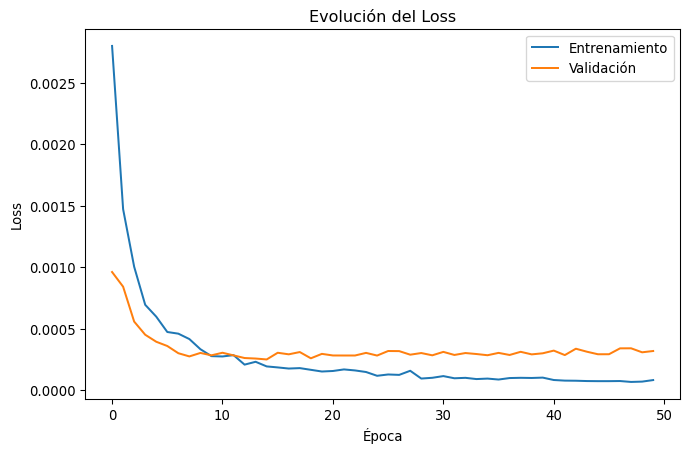

In [64]:
#| label: tu_loss
#| warning: false
import matplotlib.pyplot as plt

# Supongamos que tu entrenamiento devuelve un objeto 'history'
# history.history['loss'] contiene el loss por época
loss = history.history['loss']  
val_loss = history.history.get('val_loss')  # opcional, si tienes validación

plt.figure(figsize=(8,5))
plt.plot(loss, label='Entrenamiento')
if val_loss:
    plt.plot(val_loss, label='Validación')
plt.title('Evolución del Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.show()

## conjunto de prueba



##  Crear target CO2\_emission en test

In [65]:
#| label: crear_target_test
#| warning: false
# Crear target en test_ext
test_ext = crear_target_emisiones(test_ext)
target = 'CO2_emission'

In [66]:
#| warning: false
test_ext_filtrado = test_ext.copy()

##  Eliminar filas con CO2\_emission = 0

In [67]:
#| warning: false
test_ext_filtrado = test_ext_filtrado[test_ext_filtrado[target] != 0].copy()

---

##  Revisar cuántas filas quedan tras eliminar ceros

In [68]:
#| warning: false
print(f"Filas en test después de eliminar ceros en CO2_emission: {len(test_ext_filtrado)}")

Filas en test después de eliminar ceros en CO2_emission: 1887


---

##  Filtrar filas con target válido y revisar buques con secuencia mínima

In [69]:
#| warning: false
seq_len = 4  # longitud mínima de secuencia

# Filtrar filas con target válido
test_ext_target = test_ext_filtrado[test_ext_filtrado['CO2_emission'].notna()].copy()

# Contar buques válidos antes y después de filtrar NaN
registros_por_buque_orig = test_ext_filtrado.groupby('mmsi').size()
buques_validos_orig = (registros_por_buque_orig >= seq_len).sum()

registros_por_buque_filtrado = test_ext_target.groupby('mmsi').size()
buques_validos_filtrado = (registros_por_buque_filtrado >= seq_len).sum()

# Resumen
resumen_test = pd.DataFrame({
    'Dataset': ['Original test', 'Filtrado por target'],
    'Buques válidos': [buques_validos_orig, buques_validos_filtrado],
    'Filas totales': [len(test_ext_filtrado), len(test_ext_target)]
})

from tabulate import tabulate
print(tabulate(resumen_test, headers='keys', tablefmt='psql'))

+----+---------------------+------------------+-----------------+
|    | Dataset             |   Buques válidos |   Filas totales |
|----+---------------------+------------------+-----------------|
|  0 | Original test       |              312 |            1887 |
|  1 | Filtrado por target |              312 |            1885 |
+----+---------------------+------------------+-----------------+


---

##  Recorte de buques por secuencia mínima

In [70]:
#| warning: false
test_ext_filtrado = filtrar_buques_por_min_registros(test_ext_target, min_registros=seq_len)
print(f"Filas después del recorte por secuencia mínima en test: {len(test_ext_filtrado)}")

Filas después del recorte por secuencia mínima en test: 1631


In [71]:
#| warning: false
# Ver valores nulos en test_ext_filtrado
nulos_por_col = test_ext_filtrado.isnull().sum()
nulos_filtrados = nulos_por_col[nulos_por_col > 0]

resumen_nulos = pd.DataFrame({
    'Columna': nulos_filtrados.index,
    'Valores nulos': nulos_filtrados.values,
    'Porcentaje nulos (%)': nulos_filtrados / len(test_ext_filtrado) * 100
}).sort_values(by='Porcentaje nulos (%)', ascending=False)

from tabulate import tabulate
print(tabulate(resumen_nulos, headers='keys', tablefmt='grid', showindex=False))

+---------------------+-----------------+------------------------+
| Columna             |   Valores nulos |   Porcentaje nulos (%) |
+=====================+=================+========================+
| TotalBunkerCapacity |             310 |              19.0067   |
+---------------------+-----------------+------------------------+
| MainEngineRPM       |              13 |               0.797057 |
+---------------------+-----------------+------------------------+
| FuelType1Capacity   |               5 |               0.30656  |
+---------------------+-----------------+------------------------+


## definir vairables de entrada 

In [72]:
#| warning: false
X_test = test_ext_filtrado.drop(columns=[target])
y_test = test_ext_filtrado[target]

In [73]:
#| warning: false
# Columnas a imputar en test
columnas_num = ['TotalBunkerCapacity', 'MainEngineRPM', 'FuelType1Capacity']
flags = ['TotalBunkerCapacity']  # opcional: marcar dónde había nulos
columnas_cat = []  # no hay categóricas con nulos

# Aplicar imputación al test usando stats del train
X_test_imputado, _, _ = imputar_datos(
    X_test,
    columnas_numericas=columnas_num,
    columnas_categoricas=columnas_cat,
    flags_nulos=flags,
    medianas=medianas,  # de X_train_int_imputado
    modas=modas
)

## features

In [74]:
#| warning: false
X_test_features = crear_features(X_test_imputado)

## ajustes de correlaciones

In [75]:
#| warning: false
X_test_sin_corr = X_test_imputado.drop(columns=columns_to_drop)

print(f"Columnas en test antes de eliminar correladas: {X_test_imputado.shape[1]}")
print(f"Columnas en test después de eliminar correladas: {X_test_sin_corr.shape[1]}")

Columnas en test antes de eliminar correladas: 51
Columnas en test después de eliminar correladas: 33


In [76]:
#| warning: false
from tabulate import tabulate

# Resumen de columnas finales del test
resumen_test_final = pd.DataFrame({
    "Columnas finales": X_test_sin_corr.columns,
    "Tipo": X_test_sin_corr.dtypes.values
})

print(tabulate(resumen_test_final, headers="keys", tablefmt="psql"))

+----+--------------------------------+---------------------+
|    | Columnas finales               | Tipo                |
|----+--------------------------------+---------------------|
|  0 | mmsi                           | int32               |
|  1 | start_leg                      | datetime64[ns, UTC] |
|  2 | end_leg                        | datetime64[ns, UTC] |
|  3 | h3_sequence                    | object              |
|  4 | imo_x                          | int32               |
|  5 | ref_in                         | datetime64[us]      |
|  6 | ref_out                        | datetime64[us]      |
|  7 | port_before                    | object              |
|  8 | country_before                 | object              |
|  9 | port_after                     | object              |
| 10 | country_after                  | object              |
| 11 | op_phase                       | object              |
| 12 | StandardVesselType_x           | object              |
| 13 | G

## features test

In [77]:
#| warning: false
# Features numéricas (las que se escalan)
numeric_features = [
    'GrossTonnage_x', 'sum_me_ene', 'sum_ab_ene',
    'Speedmax', 'BreadthExtreme', 'FuelType1Capacity',
    'MainEngineRPM', 'Powerkwservice', 'combustible_ab',
    'TotalBunkerCapacity_is_missing'
]

# Features categóricas (objetos), excluyendo 'h3_sequence'
categorical_features = [
    'port_before', 'country_before', 'port_after', 'country_after',
    'op_phase', 'StandardVesselType_x', 'MainEngineModel', 
    'MainEngineType', 'PropulsionType', 'ShiptypeLevel5',
    'StandardVesselType_y', 'fuel', 'meType'
]

In [78]:
#| warning: false
# Escalar columnas numéricas
X_test_scaled = X_test_sin_corr.copy()
X_test_scaled[numeric_features] = scaler.transform(X_test_scaled[numeric_features])

#  Convertir categóricas a string
X_test_scaled[categorical_features] = X_test_scaled[categorical_features].astype(str)

#  Codificación One-Hot usando encoder ya ajustado
X_test_enc = encoder.transform(X_test_scaled)
X_test_df = pd.DataFrame(X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc)


In [79]:
#| warning: false
#  Escalar variable objetivo
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1))


In [80]:
#| warning: false
#  Crear secuencias para LSTM
X_test_scaled_reset = X_test_scaled.reset_index(drop=True)
X_test_scaled_reset['index_original'] = X_test_scaled_reset.index

X_test_seq, y_test_seq, idx_test_seq = create_sequences(
    X_test_df.values, y_test_scaled, X_test_scaled_reset, seq_len
)


In [81]:
#| warning: false
#  Evaluar modelo
loss, mae = model.evaluate(X_test_seq, y_test_seq)
print("Test Loss:", loss, "Test MAE:", mae)

 1/12 ━━━━━━━━━━━━━━━━━━━━ 3s 275ms/step - loss: 1.4128e-04 - mae: 0.0043

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8030e-04 - mae: 0.0050  


Test Loss: 0.00018030412320513278 Test MAE: 0.004961726255714893


In [82]:
#| warning: false
# Obtener predicciones en el test
y_test_pred = model.predict(X_test_seq)

# Reconstrucción con índices originales
df_results_test = pd.DataFrame({
    "index_original": idx_test_seq,
    "y_true": y_test_seq.flatten(),
    "y_pred": y_test_pred.flatten()
})

# Ver las primeras filas
df_results_test.head()

 1/12 ━━━━━━━━━━━━━━━━━━━━ 2s 197ms/step

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  


,index_original,y_true,y_pred
0,1621,0.000053,0.001364
1,791,0.000052,0.001750
2,752,0.000602,0.001954
3,260,0.000163,0.001769
4,261,0.014625,0.011861


In [83]:
#| warning: false
df_results_test.to_csv("df_results_test.csv", index=False)

In [84]:
# Extraer mmsi para cada predicción
df_results_test['mmsi'] = X_test_scaled_reset.loc[df_results_test['index_original'], 'mmsi'].values

# Elegir un MMSI aleatorio del conjunto de prueba
import numpy as np
mmsi_random = np.random.choice(df_results_test['mmsi'].unique())

# Filtrar predicciones de ese buque
df_buque = df_results_test[df_results_test['mmsi'] == mmsi_random]
print(df_buque)

     index_original   y_true    y_pred       mmsi
313             501  0.00025  0.002559  636016650


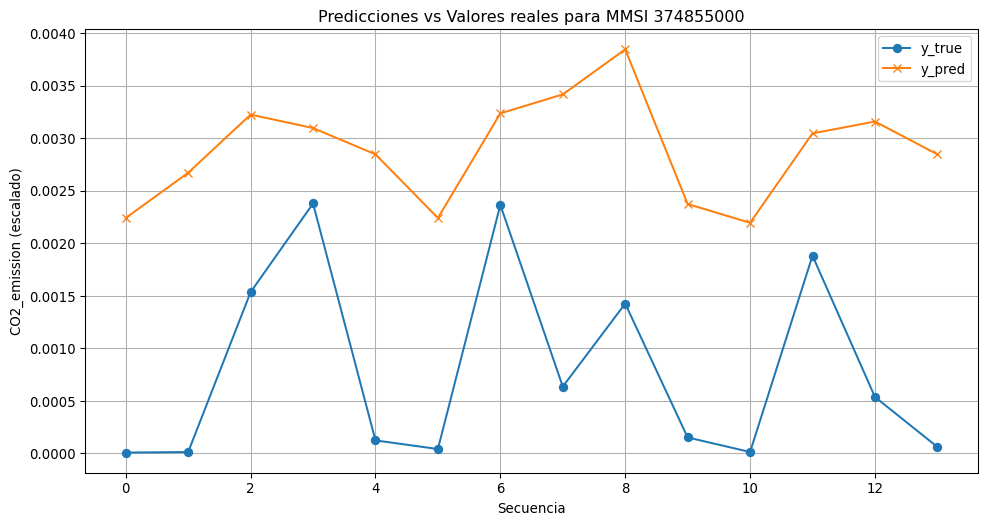

In [85]:
import matplotlib.pyplot as plt


# Contar cuántos registros tiene cada MMSI
conteo_buques = df_results_test['mmsi'].value_counts()

# Elegir un MMSI con al menos, por ejemplo, 5 secuencias
mmsi_ejemplo = conteo_buques[conteo_buques >= 5].index[0]

# Filtrar predicciones de ese buque
df_buque = df_results_test[df_results_test['mmsi'] == mmsi_ejemplo]

# Graficar
plt.figure(figsize=(12,6))
plt.plot(df_buque['y_true'].values, label='y_true', marker='o')
plt.plot(df_buque['y_pred'].values, label='y_pred', marker='x')
plt.title(f'Predicciones vs Valores reales para MMSI {mmsi_ejemplo}')
plt.xlabel('Secuencia')
plt.ylabel('CO2_emission (escalado)')
plt.legend()
plt.grid(True)
plt.show()